# Tephra2 Inversion (Simulated) — Simulation Demo

This notebook:
1. (Optionally) builds a synthetic Cerro Negro-style dataset via `scripts.sim.setup`,
2. (Optionally) runs the simulation grid via `scripts.sim.simulate`,
3. Aggregates chains across N_REPEATS and produces demo plots for a subset of
   priors and hyperparameters (MCMC, SA, PSO, ES).

Plots are saved under:
  data_sim_cerro/output/trace/
  data_sim_cerro/output/marginals/

In [1]:
import os
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "DejaVu Sans"
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [2]:
# Toggle between test config and main config
USE_TEST_CONFIG = True

if USE_TEST_CONFIG:
    from scripts.sim import exp_config_test as exp_cfg
    CONFIG_MODULE = "scripts.sim.exp_config_test"
else:
    from scripts.sim import exp_config as exp_cfg
    CONFIG_MODULE = "scripts.sim.exp_config"

SIM_OUTPUT_DIR = Path(exp_cfg.SIM_OUTPUT_DIR)
N_REPEATS = exp_cfg.N_REPEATS

print(f"CONFIG_MODULE = {CONFIG_MODULE}")
print(f"SIM_OUTPUT_DIR = {SIM_OUTPUT_DIR}")
print(f"N_REPEATS      = {N_REPEATS}")

from scripts.sim.aggregate_sim_visuals import make_demo_plots

CONFIG_MODULE = scripts.sim.exp_config_test
SIM_OUTPUT_DIR = data_sim_cerro/experiments_test
N_REPEATS      = 1


## Optional: build simulated dataset (`scripts.sim.setup`)

Run this **once** to create the `data_sim_cerro/` tree from an aggregated
Cerro Negro CSV. After it has been created, you can leave `RUN_SETUP=False` for subsequent runs.

In [3]:
RUN_SETUP = False  # flip to True the first time you prepare data_sim_cerro

SETUP_CMD = (
    "python -m scripts.sim.setup "
    "data_std/cn_std_agg.csv "
    "--out-root data_sim_cerro "
    "--vent-easting 532400 "
    "--vent-northing 1382525 "
    "--vent-elev 100 "
    "--plume-height 7000 "
    "--eruption-mass 2.4e10"
)

if RUN_SETUP:
    print("Running synthetic setup via:\n", SETUP_CMD)
    ret = os.system(SETUP_CMD)
    print(f"\nsetup exit code: {ret}")
else:
    print("Skipping setup (RUN_SETUP=False).")
    print("Set RUN_SETUP=True if you need to create or refresh data_sim_cerro/.")

Skipping setup (RUN_SETUP=False).
Set RUN_SETUP=True if you need to create or refresh data_sim_cerro/.


## Optional: launch simulations (`scripts.sim.simulate`)

This will run *all* combinations defined in the chosen config module (`exp_config_test` or `exp_config`) for N_REPEATS.

Only enable this when you actually want to generate or refresh the experiment results in `SIM_OUTPUT_DIR`.

In [4]:
RUN_SIM = False  # flip to True when you actually want to run the experiment grid

if RUN_SIM:
    print(f"Running simulations with config module: {CONFIG_MODULE}")
    !python -m scripts.sim.simulate --config-module {CONFIG_MODULE}
else:
    print("Skipping simulation (RUN_SIM=False).")
    print("Set RUN_SIM=True to run scripts.sim.simulate.")

Skipping simulation (RUN_SIM=False).
Set RUN_SIM=True to run scripts.sim.simulate.


## Aggregate demo plots

We now aggregate across N_REPEATS and produce:
* multi-trace plots (10 light traces + bold mean trajectory),
* marginal histograms (all samples + histogram of per-index mean).

Plots are written to:
  data_sim_cerro/output/trace/
  data_sim_cerro/output/marginals/

You can change DEMO_PRIORS and hyperparameters below as needed.

In [5]:
# ---------------------------------------------------------------------
# Demo subset controls (can be changed per notebook run)
# ---------------------------------------------------------------------

# Prior std scaling factors to visualize
# (must exist in the results CSVs, or you'll get a 'No runs found' error)
# DEMO_PRIORS = [2.0, 1.0, 0.5]
DEMO_PRIORS = [2.5, 1.0, 0.4]

# Hyperparameter combos for each method that we want to aggregate:
#   - SA:  runs, restarts
#   - PSO: runs, restarts
#   - ES:  n_ens, n_assimilations
#   - MCMC: n_iter
#
# These need to match what you actually used in your simulation grid.
SA_RUNS, SA_RESTARTS       = 10000, 9
PSO_RUNS, PSO_RESTARTS     = 1000,  9
ES_N_ENS, ES_N_ASSIM       = 1000,  9
MCMC_N_ITER                = 100000

In [6]:
# ---------------------------------------------------------------------
# Demo subset controls (can be changed per notebook run)
# ---------------------------------------------------------------------

# Prior std scaling factors to visualize
# (must exist in the results CSVs, or you'll get a 'No runs found' error)
DEMO_PRIORS = [2.0, 1.0, 0.5]

# Hyperparameter combos for each method that we want to aggregate:
#   - SA:  runs, restarts
#   - PSO: runs, restarts
#   - ES:  n_ens, n_assimilations
#   - MCMC: n_iter
#
# These need to match what you actually used in your simulation grid.
SA_RUNS, SA_RESTARTS       = 1000, 0
PSO_RUNS, PSO_RESTARTS     = 100,  0
ES_N_ENS, ES_N_ASSIM       = 100,  1
MCMC_N_ITER                = 1000

In [7]:
# ---------------------------------------------------------------------
# Run aggregation + plotting
# ---------------------------------------------------------------------
summary = make_demo_plots(
    sim_output_dir=SIM_OUTPUT_DIR,
    show=False,  # True if you want to see inline plots as well
    demo_priors=DEMO_PRIORS,
    sa_runs=SA_RUNS,
    sa_restarts=SA_RESTARTS,
    pso_runs=PSO_RUNS,
    pso_restarts=PSO_RESTARTS,
    es_n_ens=ES_N_ENS,
    es_n_assimilations=ES_N_ASSIM,
    mcmc_n_iter=MCMC_N_ITER,
)

print(f"\nGenerated {len(summary)} aggregate configs.\n")


Generated 12 aggregate configs.



In [8]:
# Quick tabular view of what was created
rows = []
for gr in summary:
    rows.append(
        {
            "model": gr.model,
            "prior_factor": gr.prior_factor,
            "config_index": gr.config_index,
            "n_runs": gr.n_runs,
            "n_steps": gr.n_steps,
            "trace_path": str(gr.trace_path),
            "marginals_path": str(gr.marginals_path),
        }
    )
pd.DataFrame(rows)

,model,prior_factor,config_index,n_runs,n_steps,trace_path,marginals_path
0,sa,2.0,0,1,1001,data_sim_cerro/output/trace/sa_config_0000_tra...,data_sim_cerro/output/marginals/sa_config_0000...
1,sa,1.0,1,1,1001,data_sim_cerro/output/trace/sa_config_0001_tra...,data_sim_cerro/output/marginals/sa_config_0001...
2,sa,0.5,2,1,1001,data_sim_cerro/output/trace/sa_config_0002_tra...,data_sim_cerro/output/marginals/sa_config_0002...
3,pso,2.0,0,1,101,data_sim_cerro/output/trace/pso_config_0000_tr...,data_sim_cerro/output/marginals/pso_config_000...
4,pso,1.0,1,1,101,data_sim_cerro/output/trace/pso_config_0001_tr...,data_sim_cerro/output/marginals/pso_config_000...
5,pso,0.5,2,1,101,data_sim_cerro/output/trace/pso_config_0002_tr...,data_sim_cerro/output/marginals/pso_config_000...
6,es,2.0,0,1,100,data_sim_cerro/output/trace/es_config_0000_tra...,data_sim_cerro/output/marginals/es_config_0000...
7,es,1.0,1,1,100,data_sim_cerro/output/trace/es_config_0001_tra...,data_sim_cerro/output/marginals/es_config_0001...
8,es,0.5,2,1,100,data_sim_cerro/output/trace/es_config_0002_tra...,data_sim_cerro/output/marginals/es_config_0002...
9,mcmc,2.0,0,1,1001,data_sim_cerro/output/trace/mcmc_config_0000_t...,data_sim_cerro/output/marginals/mcmc_config_00...


## Where the images are saved

For a given configuration, images are written to:

  `SIM_OUTPUT_DIR / "plots_demo" / "<model>_config_XX_trace.png"`
  `SIM_OUTPUT_DIR / "plots_demo" / "<model>_config_XX_marginals.png"`

where `<model>` is one of `mcmc`, `sa`, `pso`, `es`, and `XX` is the
`config_index` (00, 01, 02) corresponding to the order of `DEMO_PRIORS`.

For example, with `USE_TEST = True` and
`SIM_OUTPUT_DIR = "data_sim_cerro/experiments_test"`, you'll see:

  `data_sim_cerro/experiments_test/plots_demo/mcmc_config_00_trace.png`
  `data_sim_cerro/experiments_test/plots_demo/mcmc_config_00_marginals.png`
  `data_sim_cerro/experiments_test/plots_demo/sa_config_01_trace.png`
  `data_sim_cerro/experiments_test/plots_demo/sa_config_01_marginals.png`
  ... etc.

## Display all aggregate plots (traces + marginals)

SA | prior=2.0 | config=00


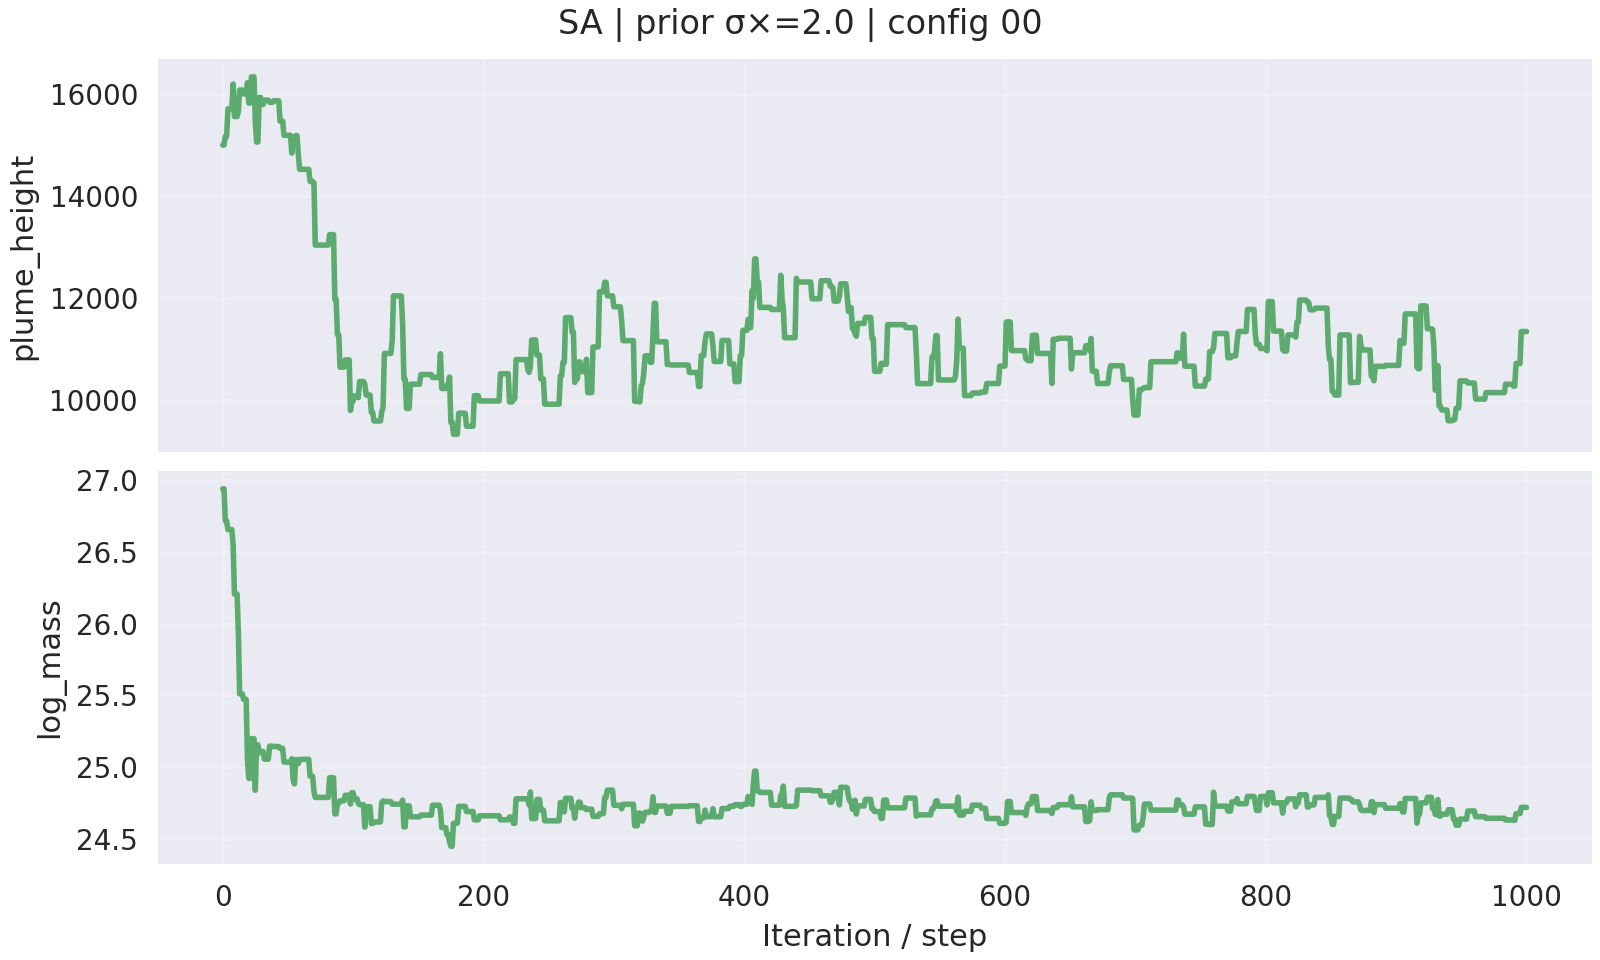

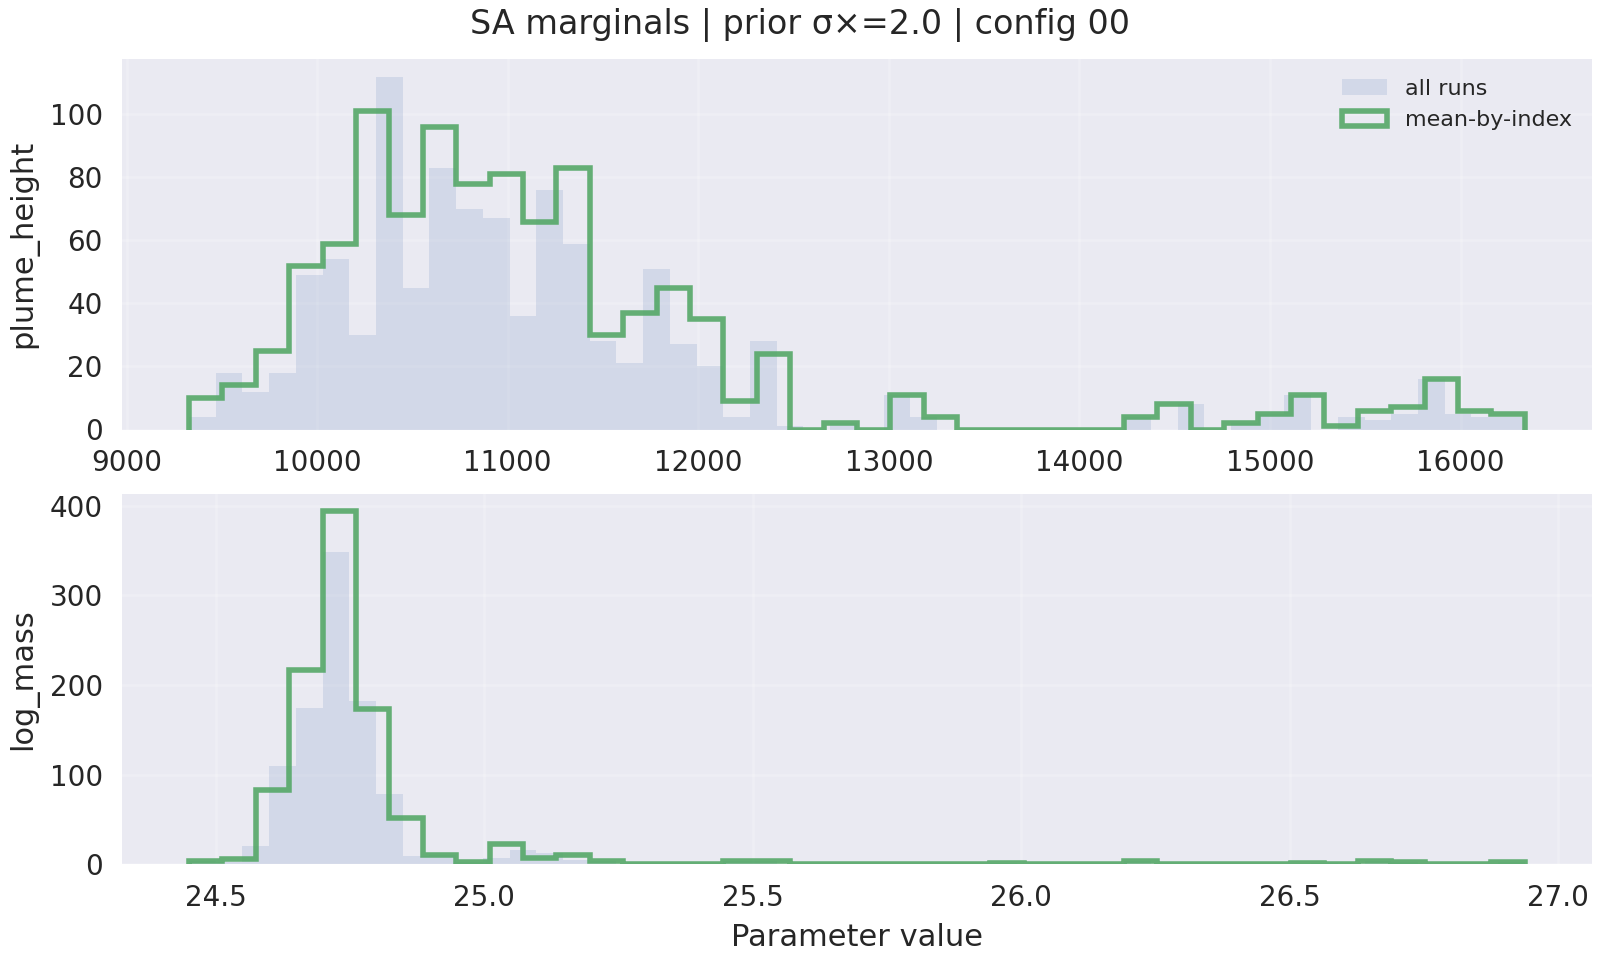

------------------------------------------------------------
SA | prior=1.0 | config=01


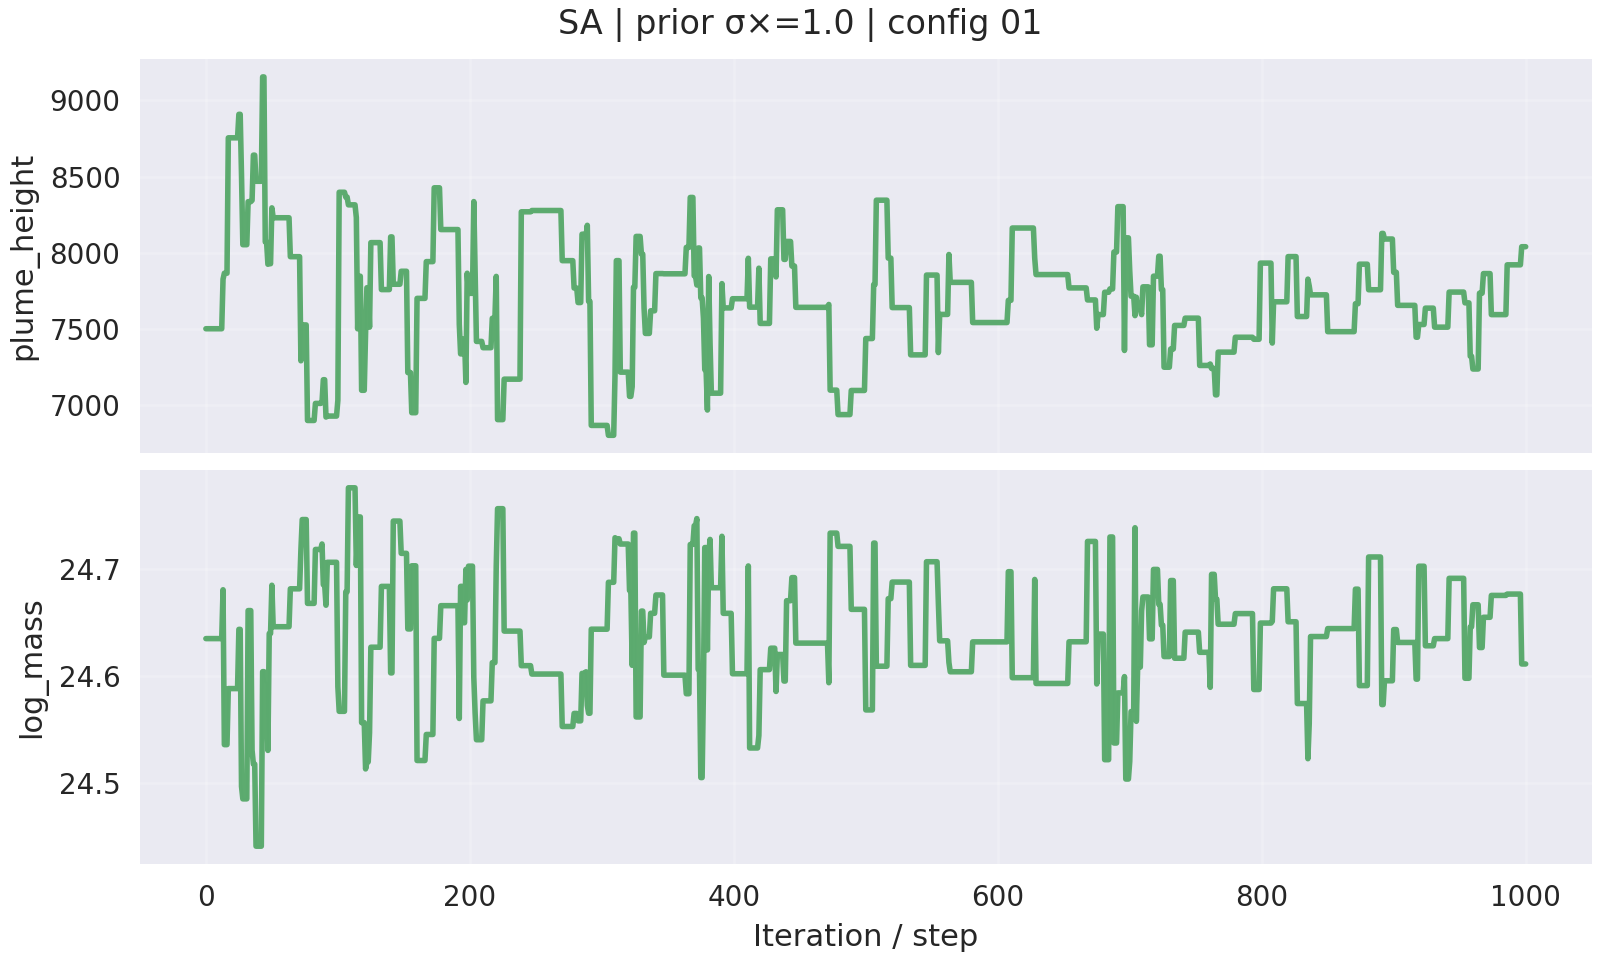

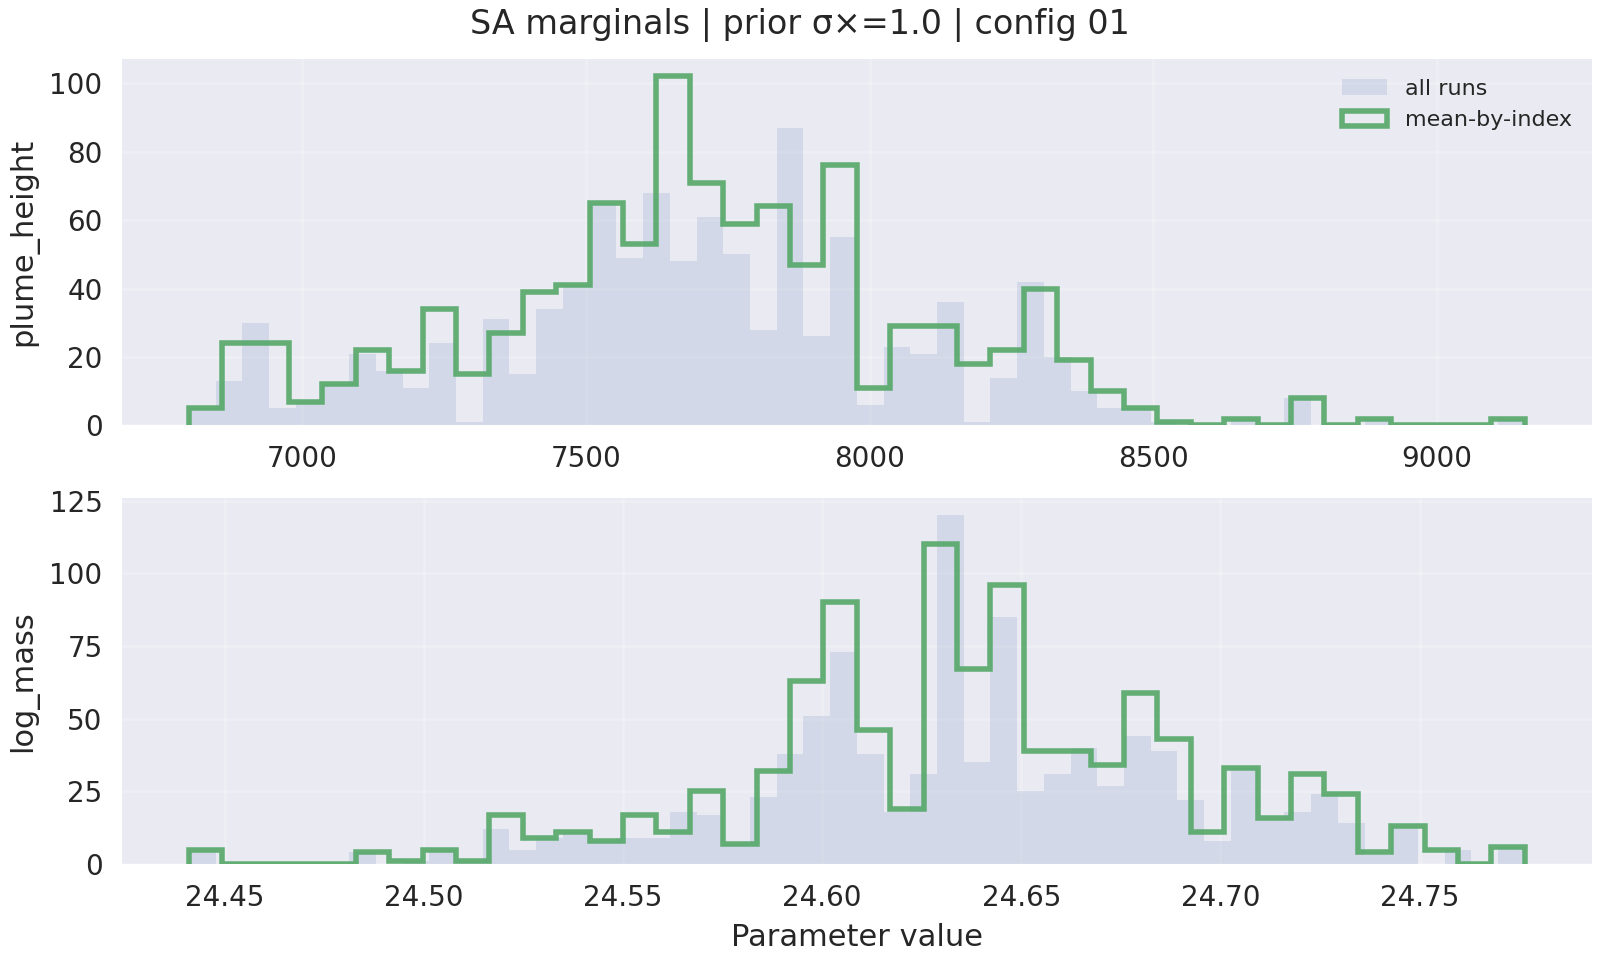

------------------------------------------------------------
SA | prior=0.5 | config=02


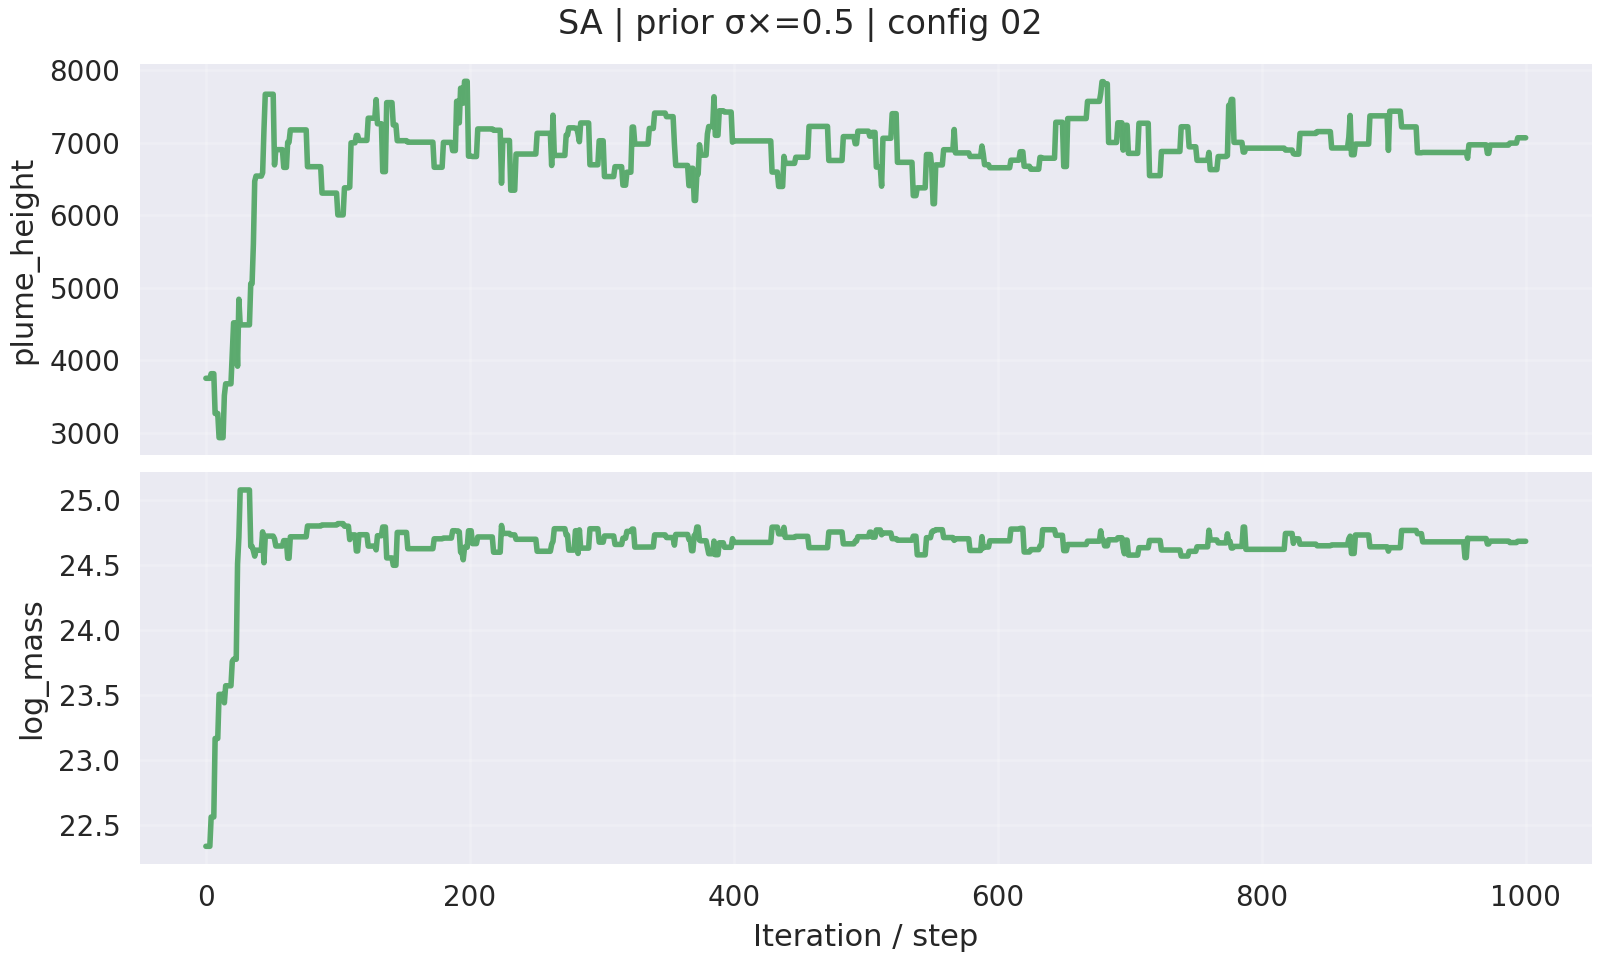

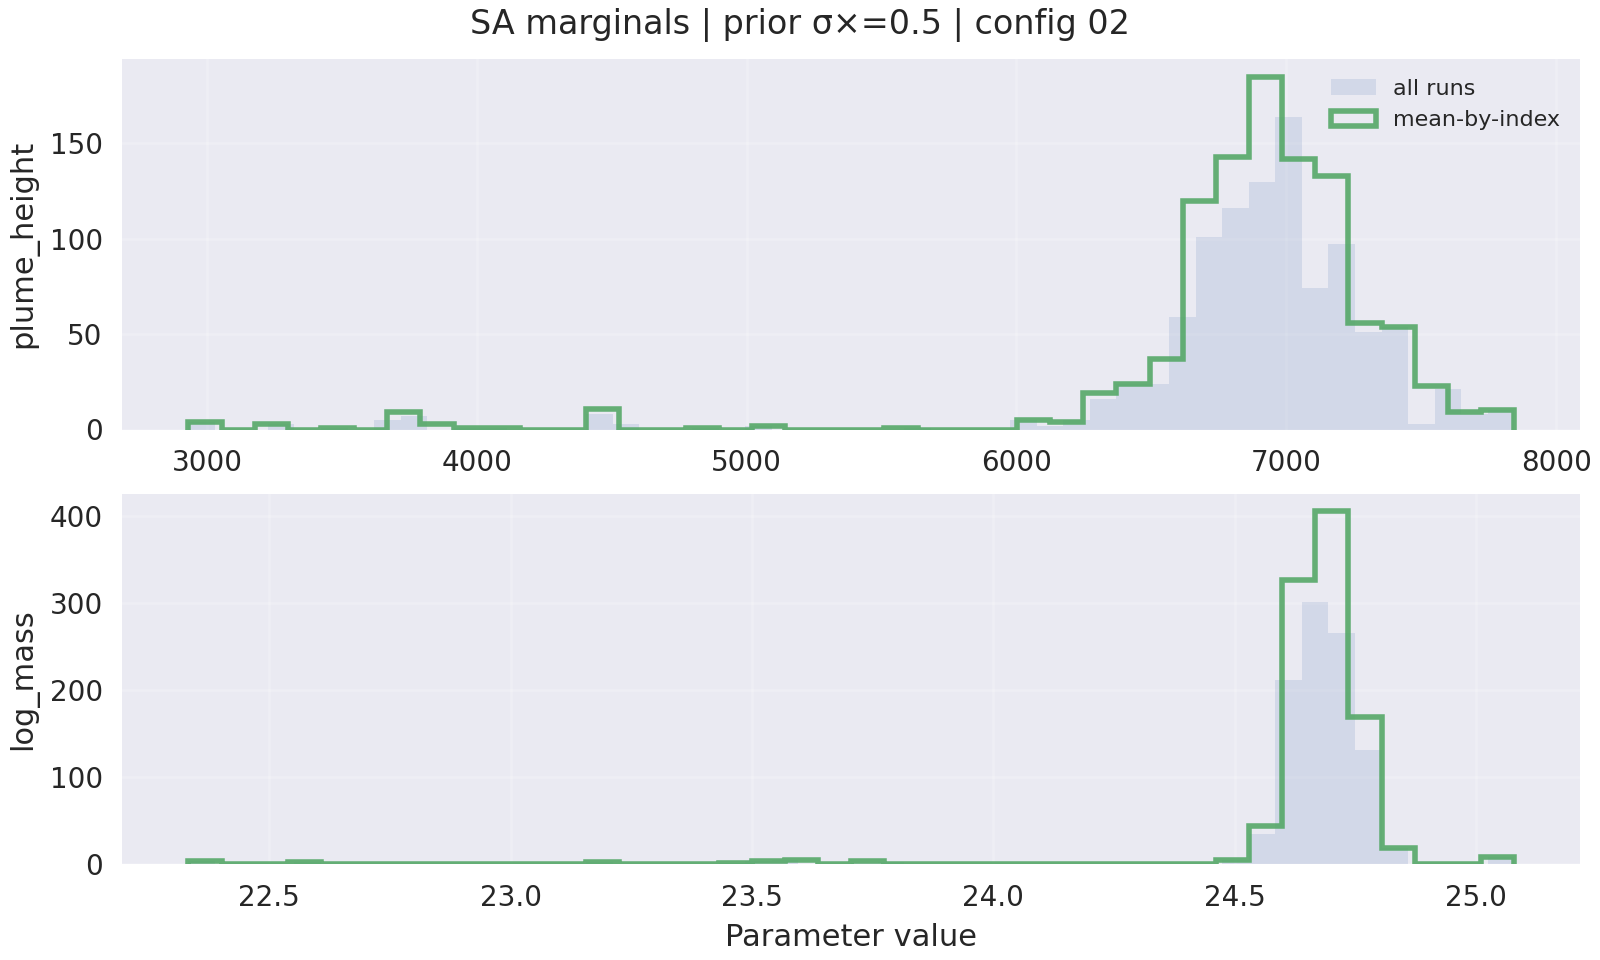

------------------------------------------------------------
PSO | prior=2.0 | config=00


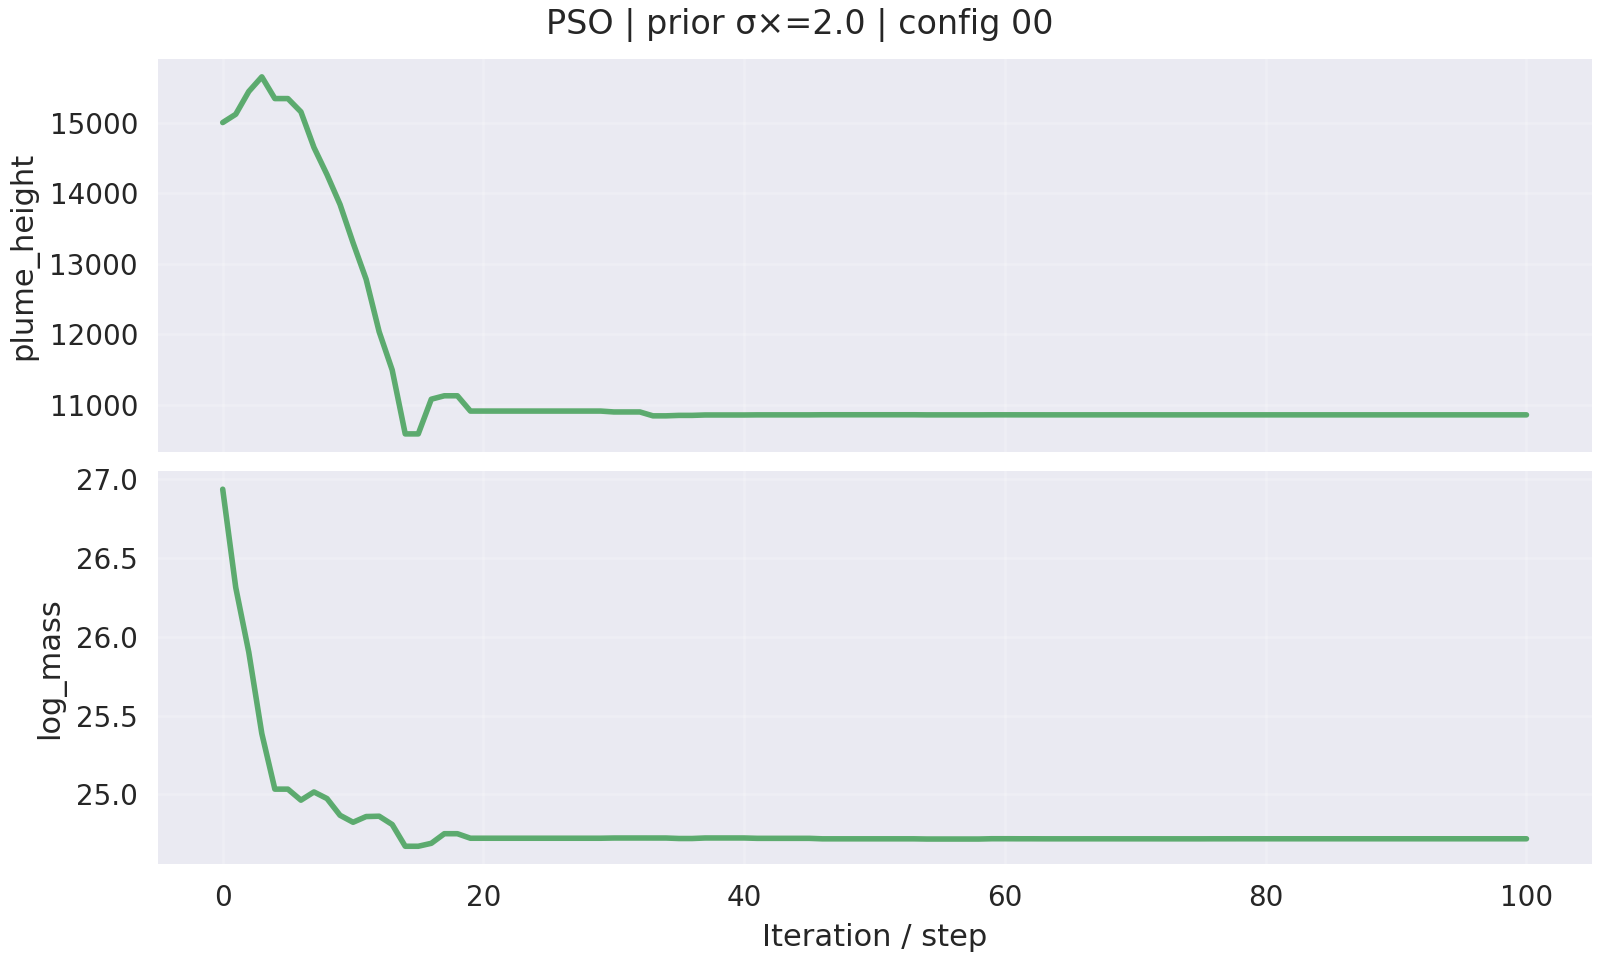

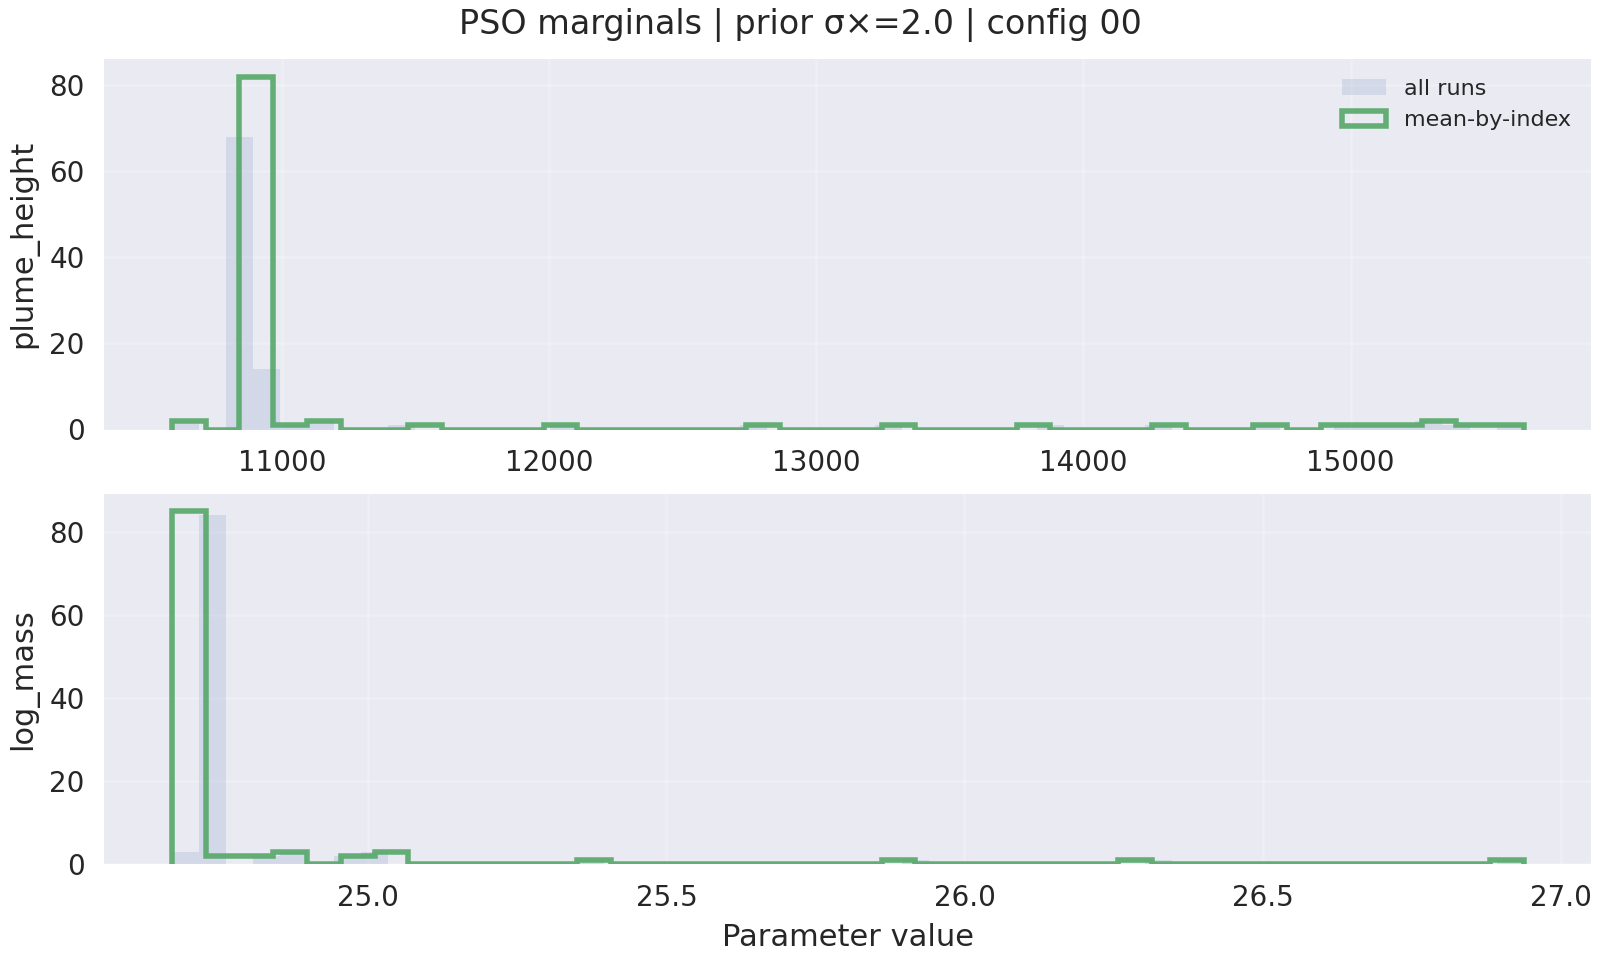

------------------------------------------------------------
PSO | prior=1.0 | config=01


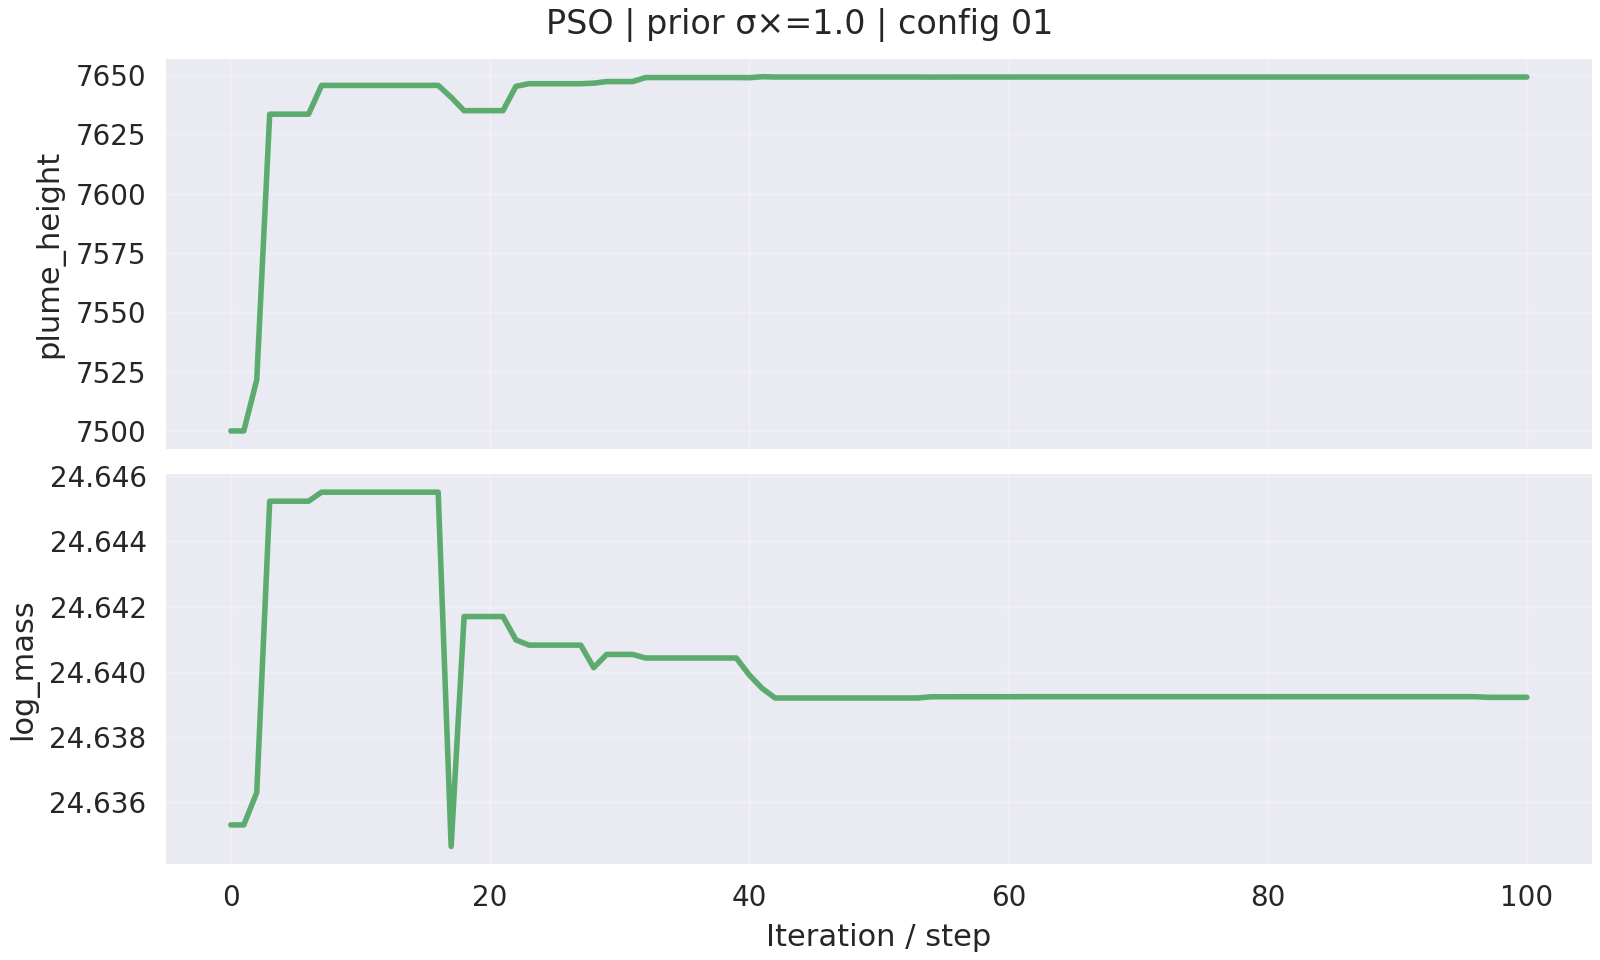

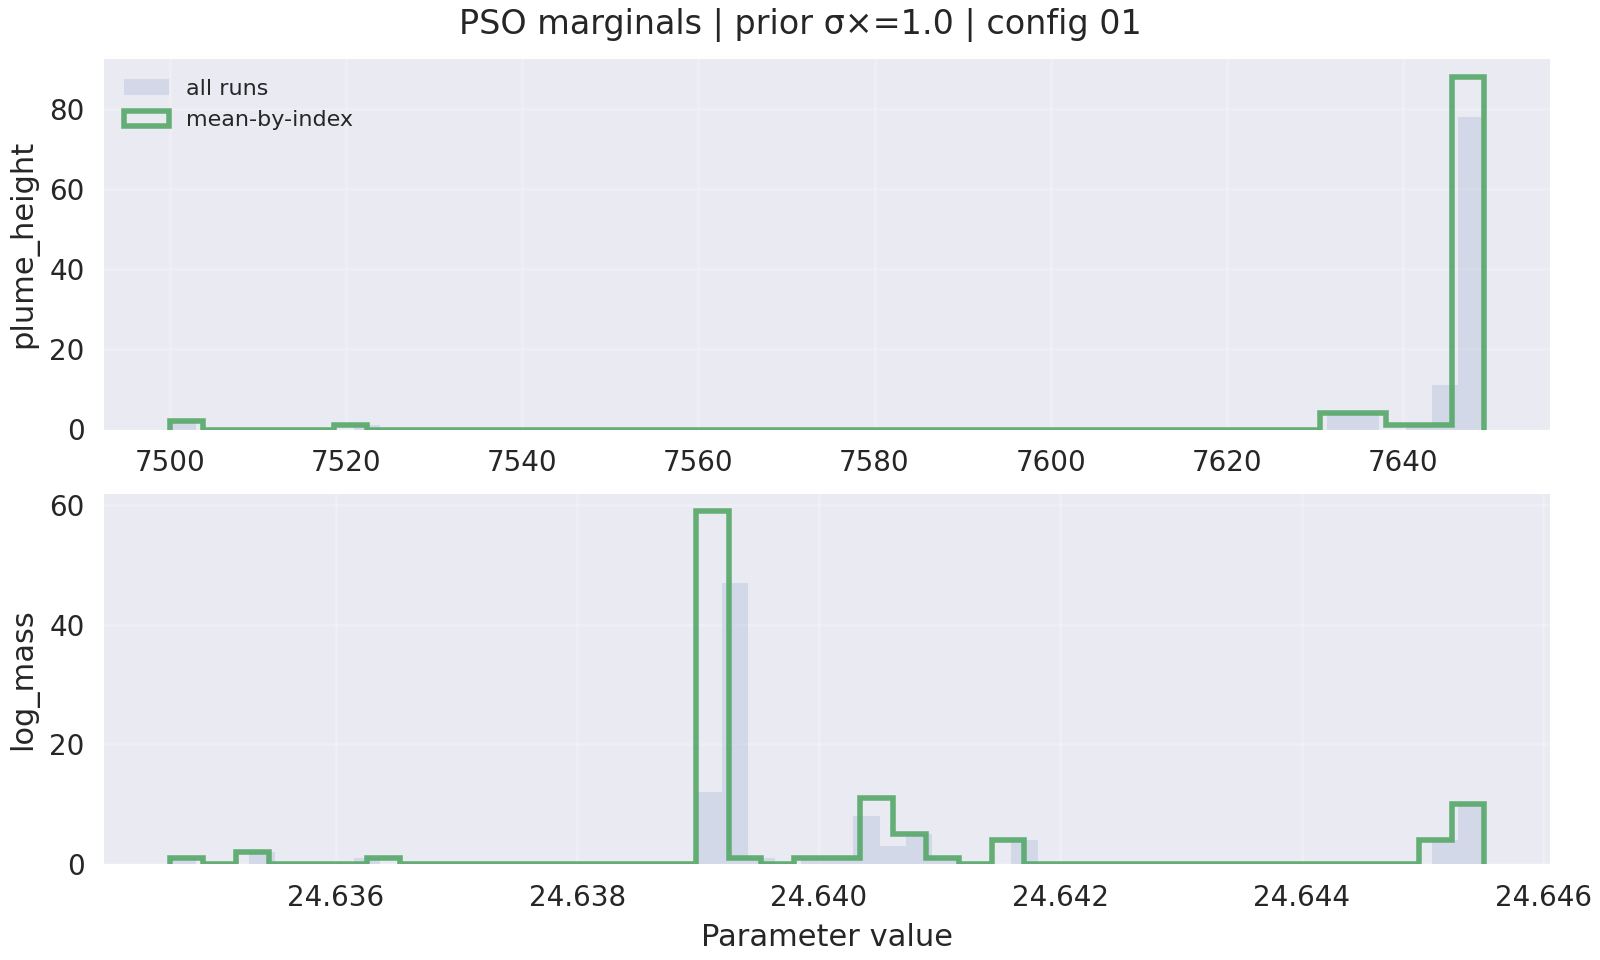

------------------------------------------------------------
PSO | prior=0.5 | config=02


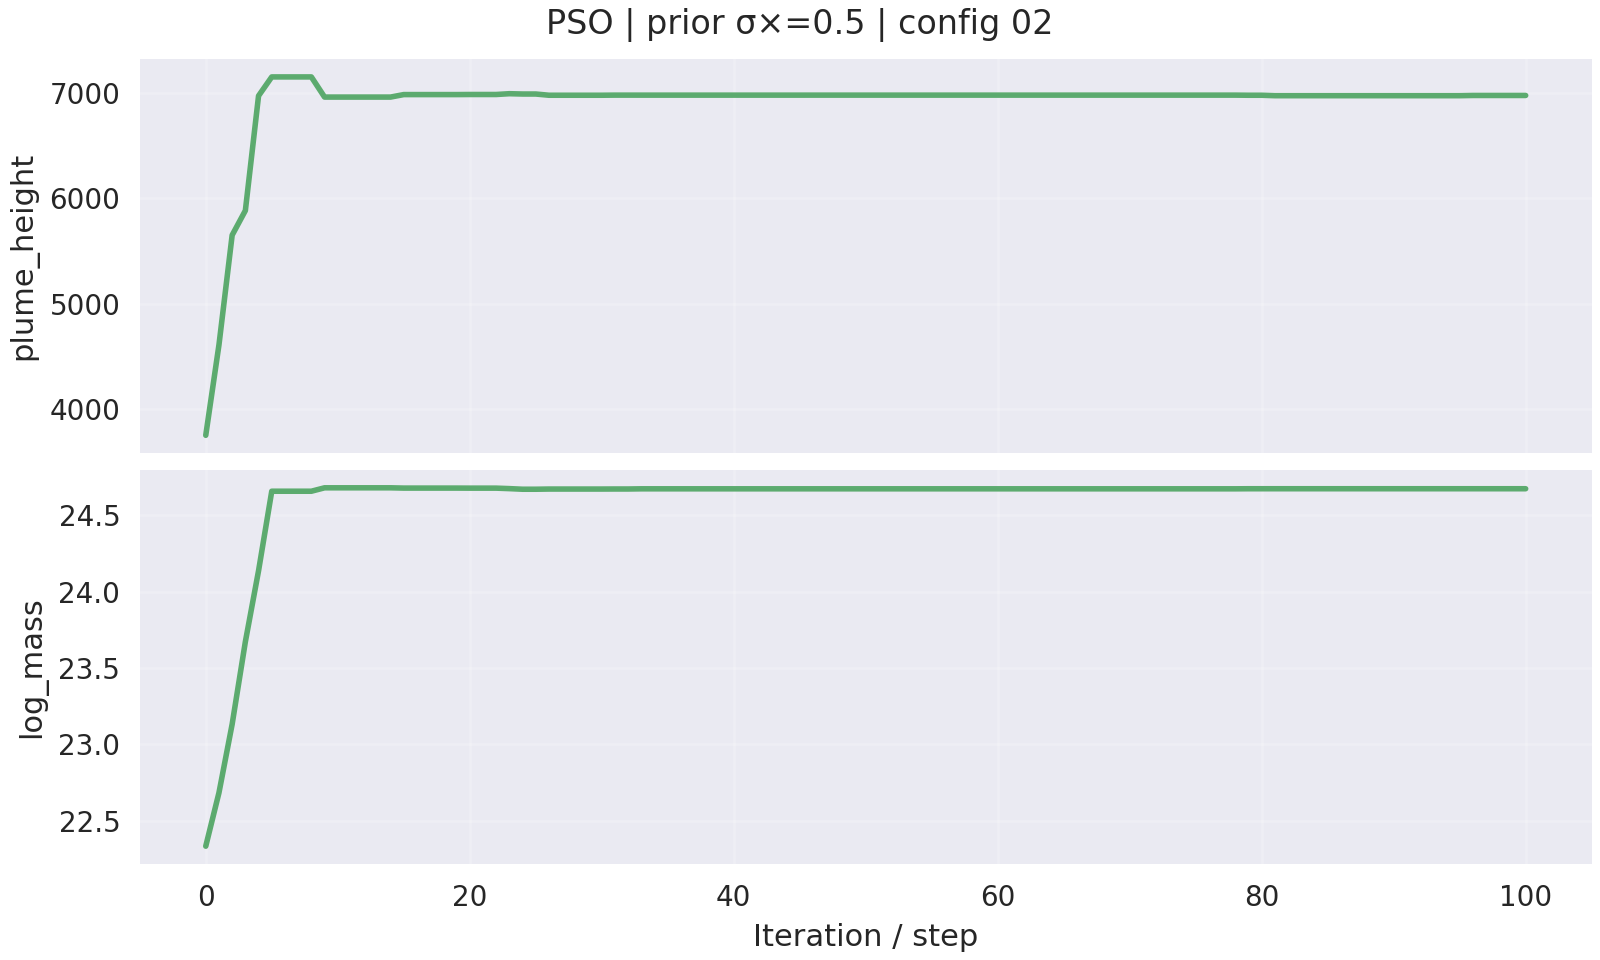

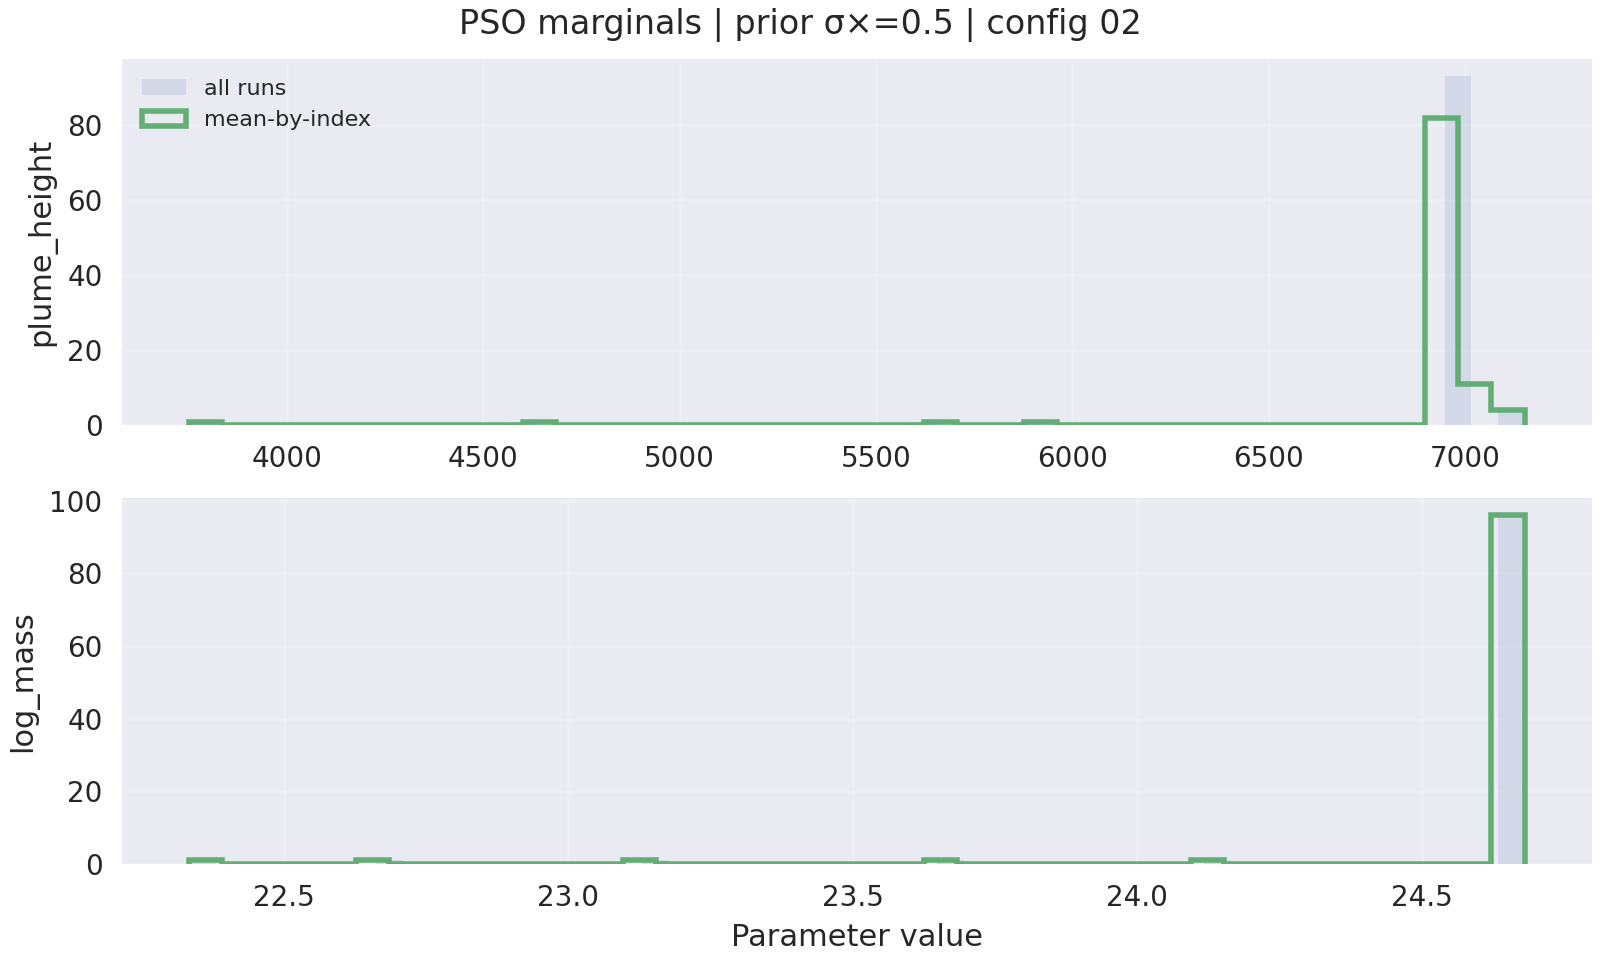

------------------------------------------------------------
ES | prior=2.0 | config=00


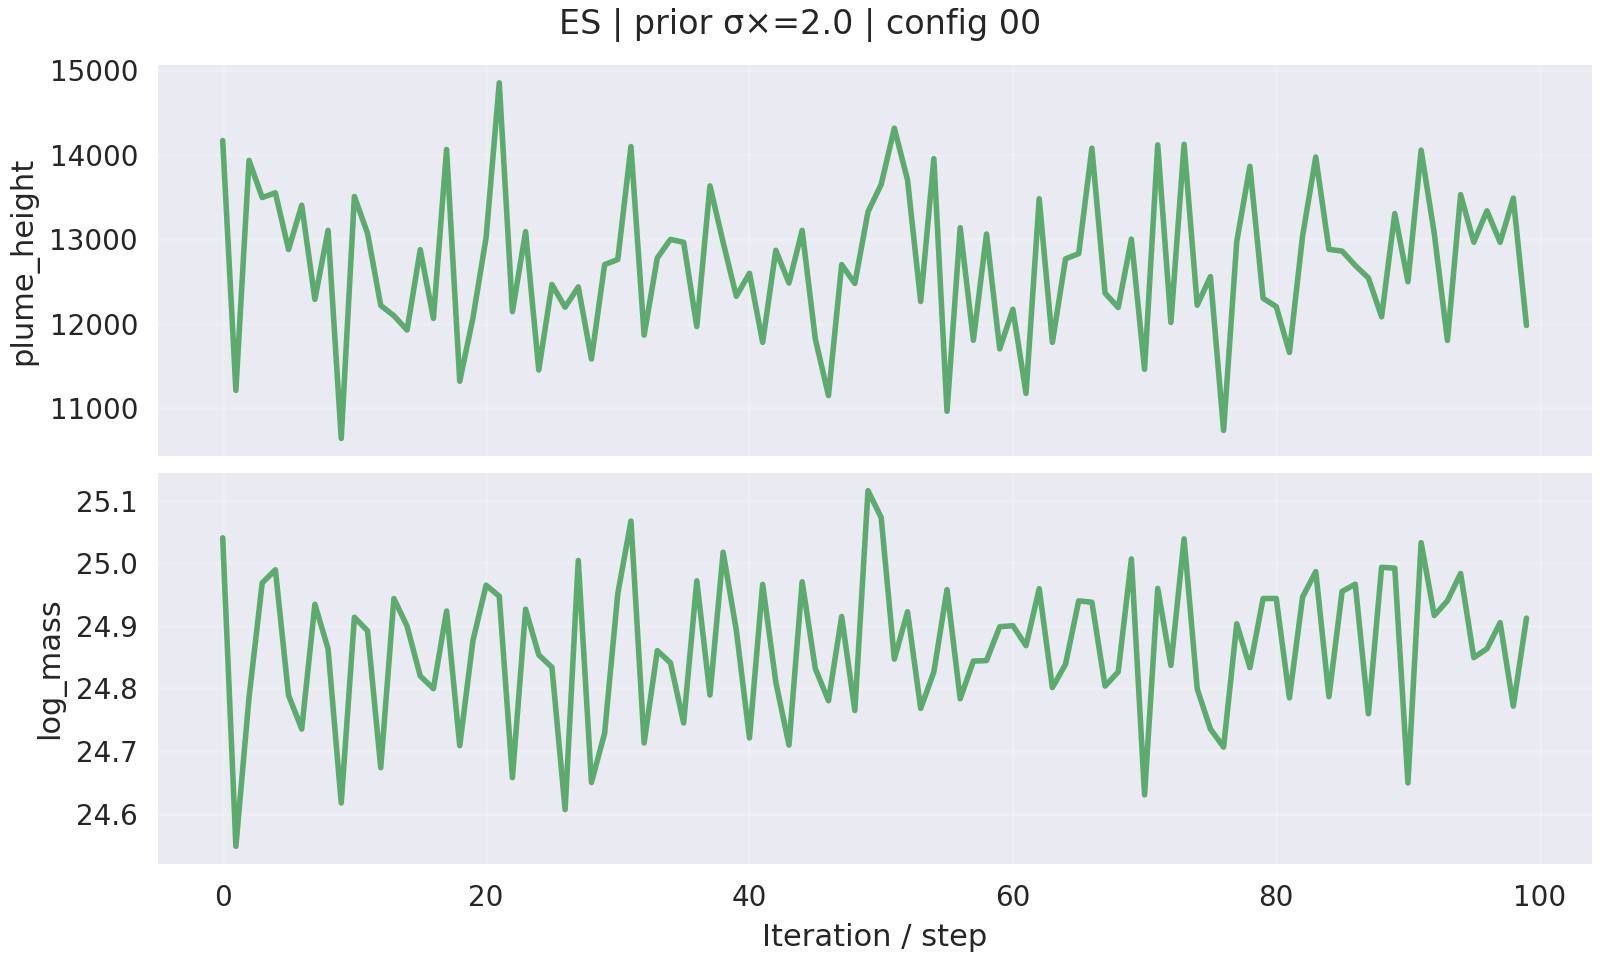

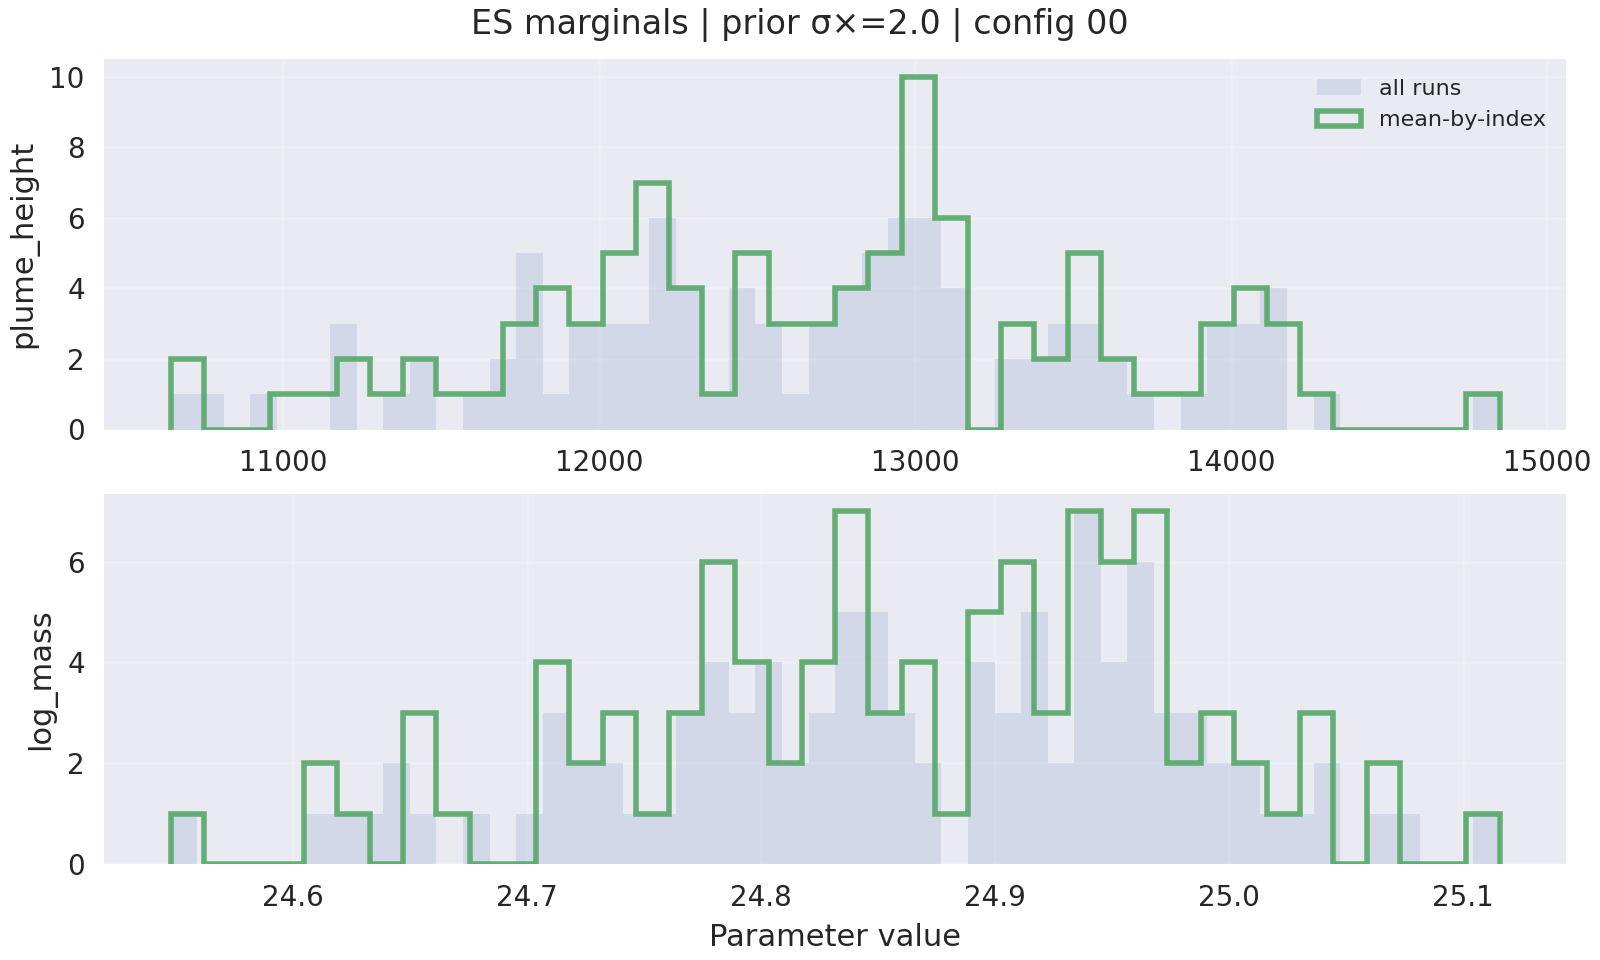

------------------------------------------------------------
ES | prior=1.0 | config=01


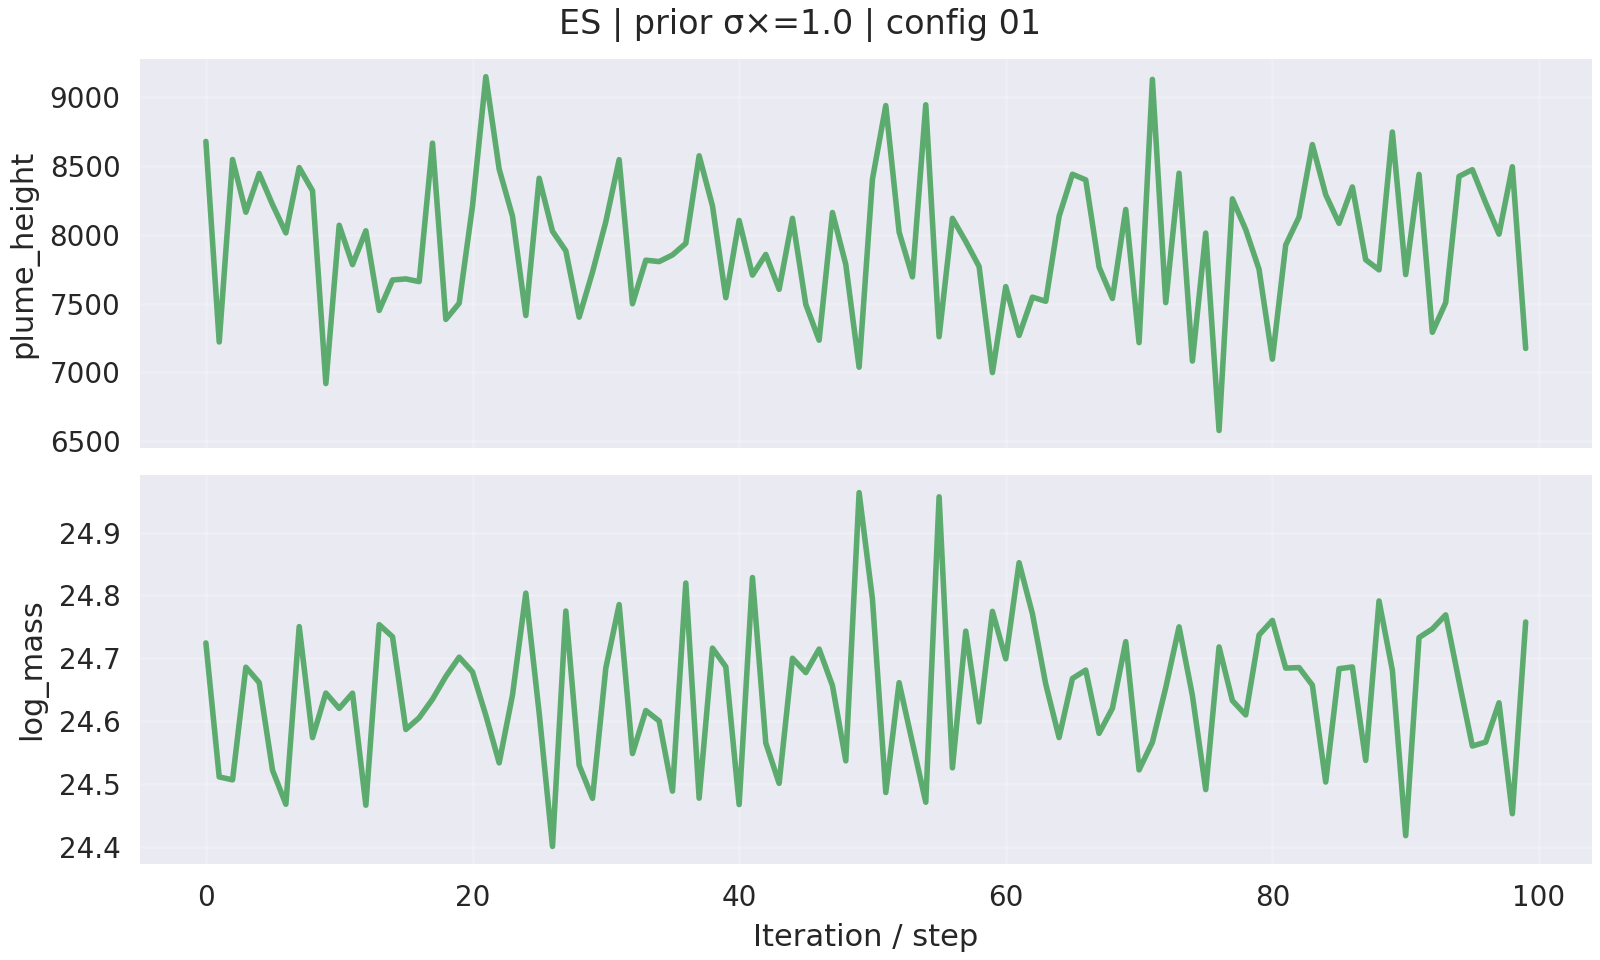

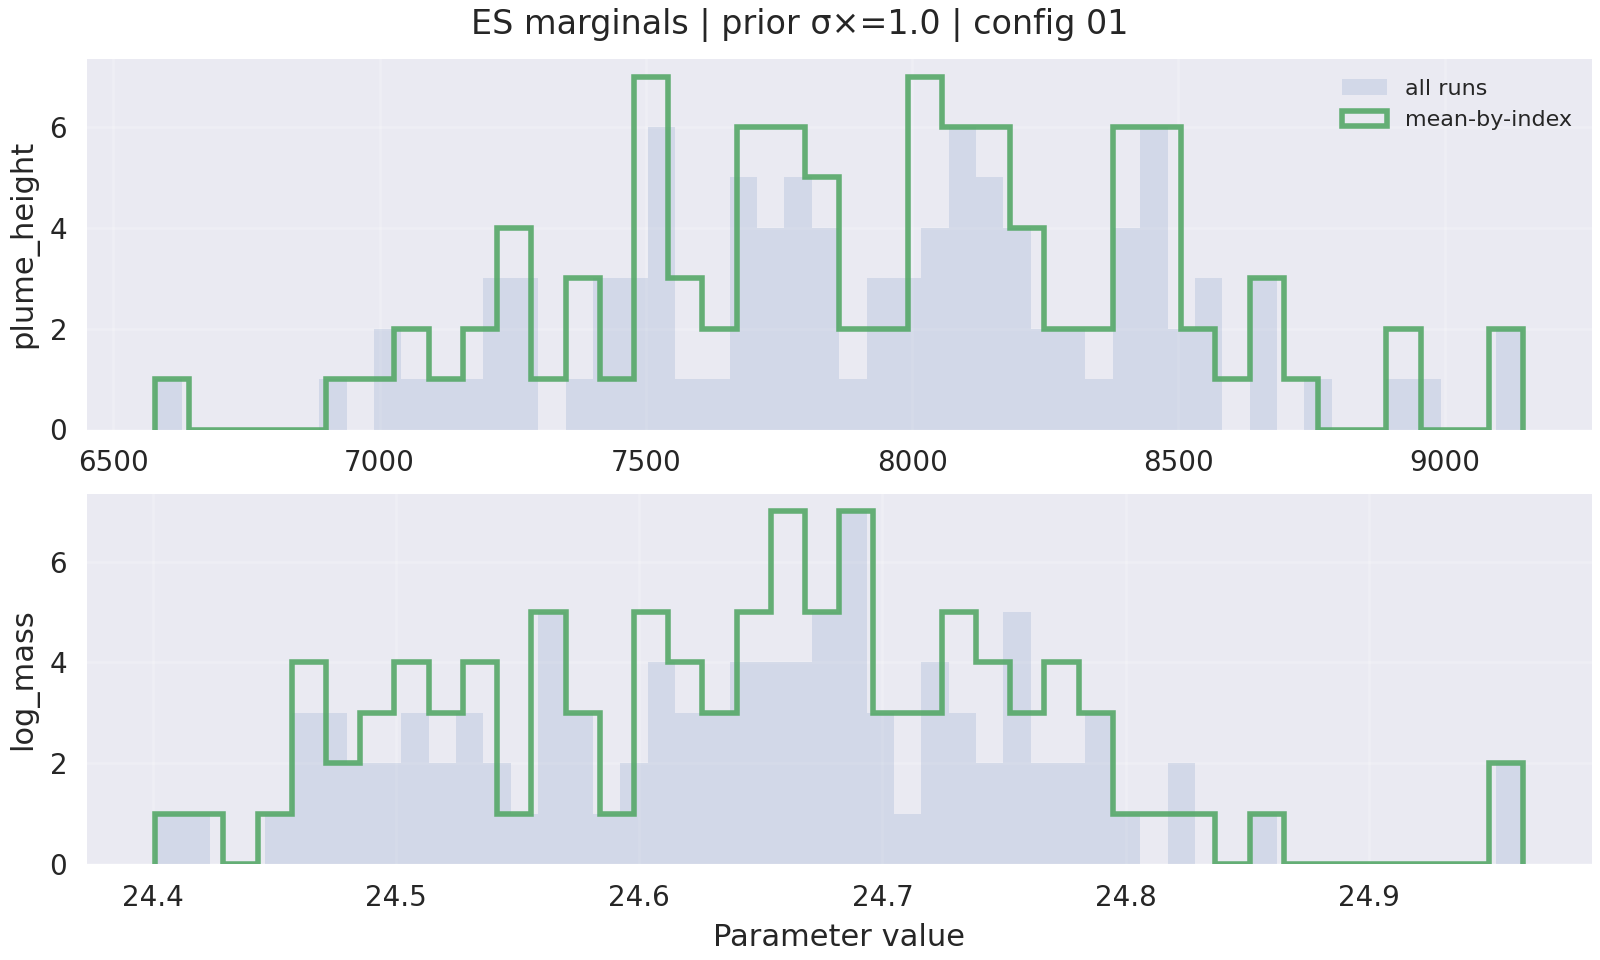

------------------------------------------------------------
ES | prior=0.5 | config=02


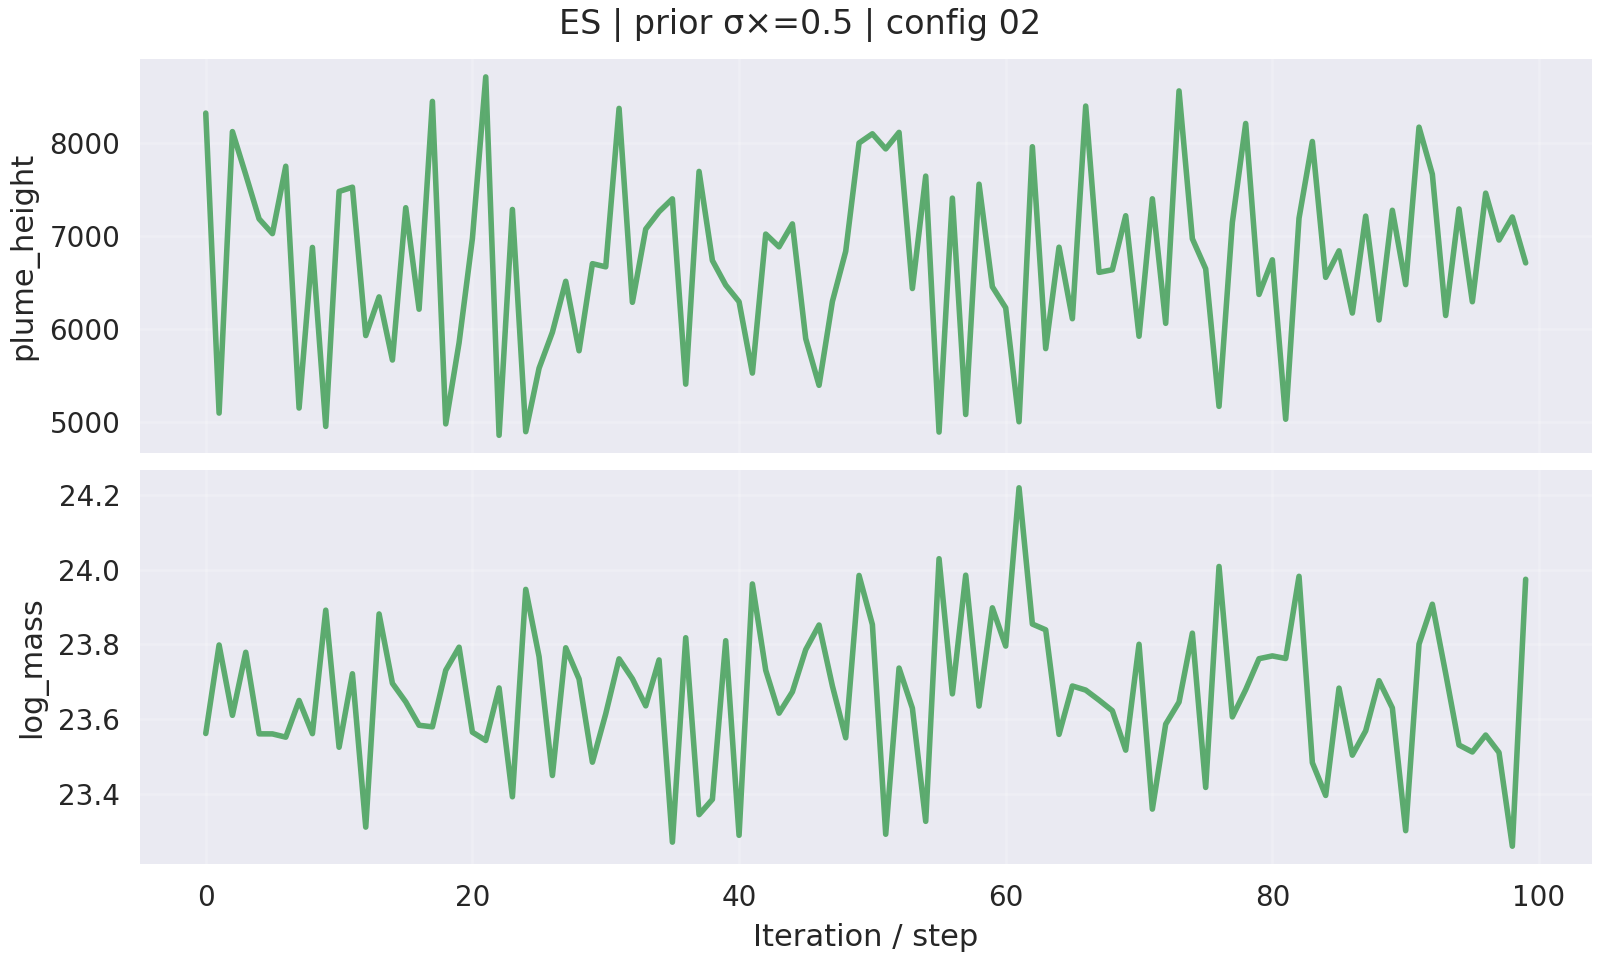

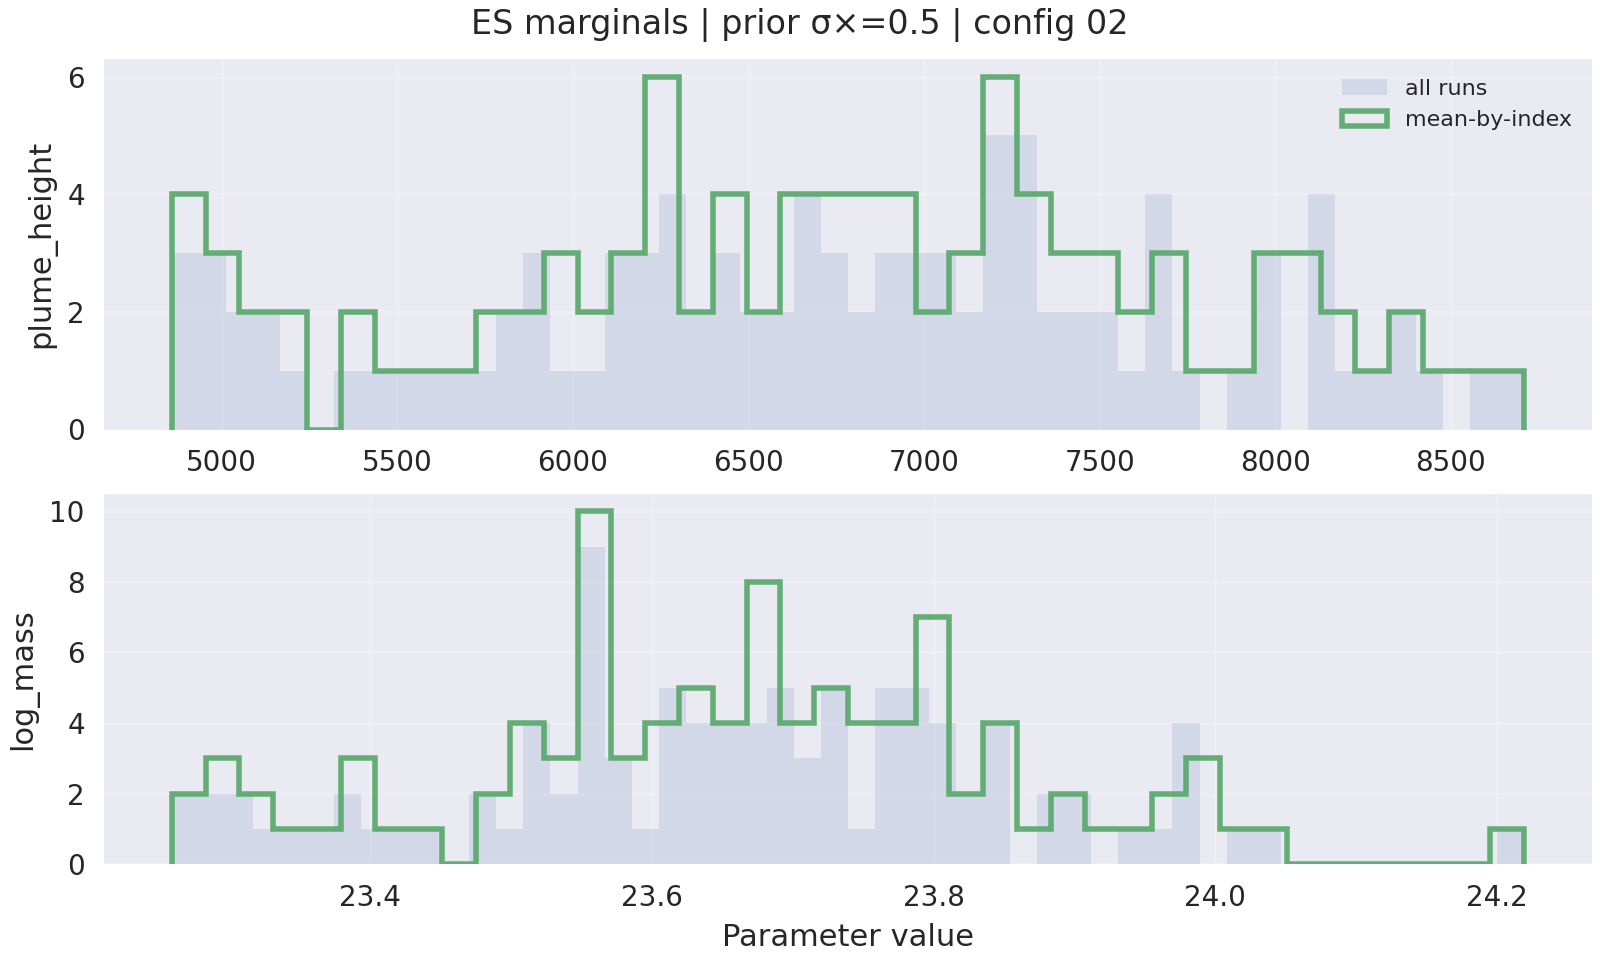

------------------------------------------------------------
MCMC | prior=2.0 | config=00


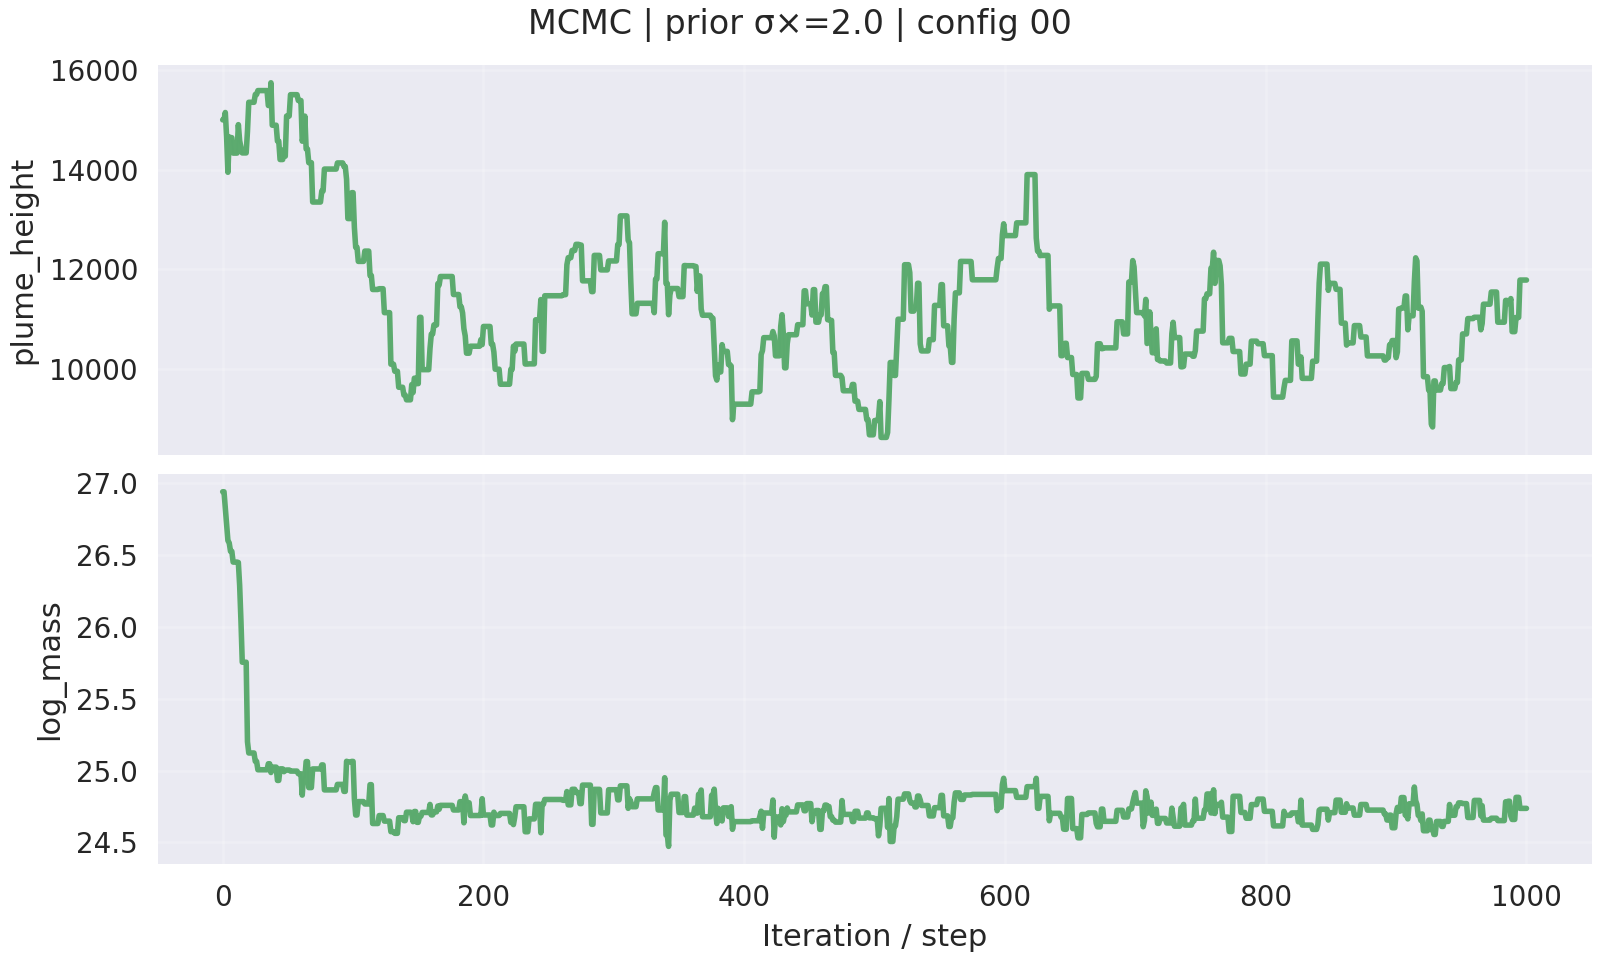

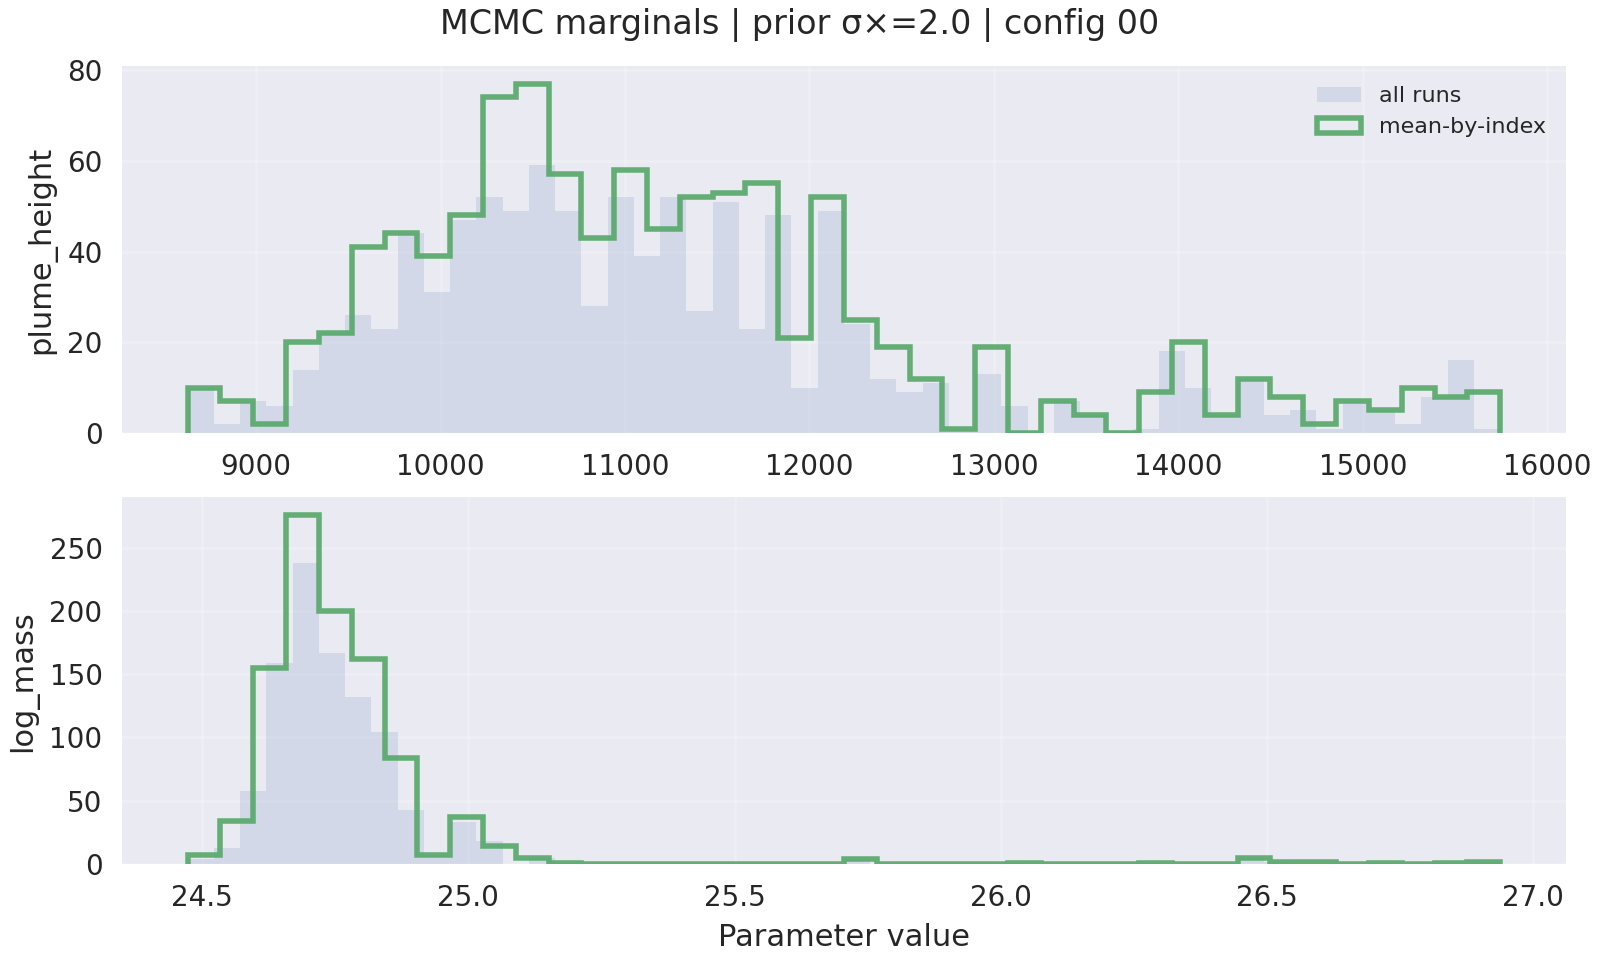

------------------------------------------------------------
MCMC | prior=1.0 | config=01


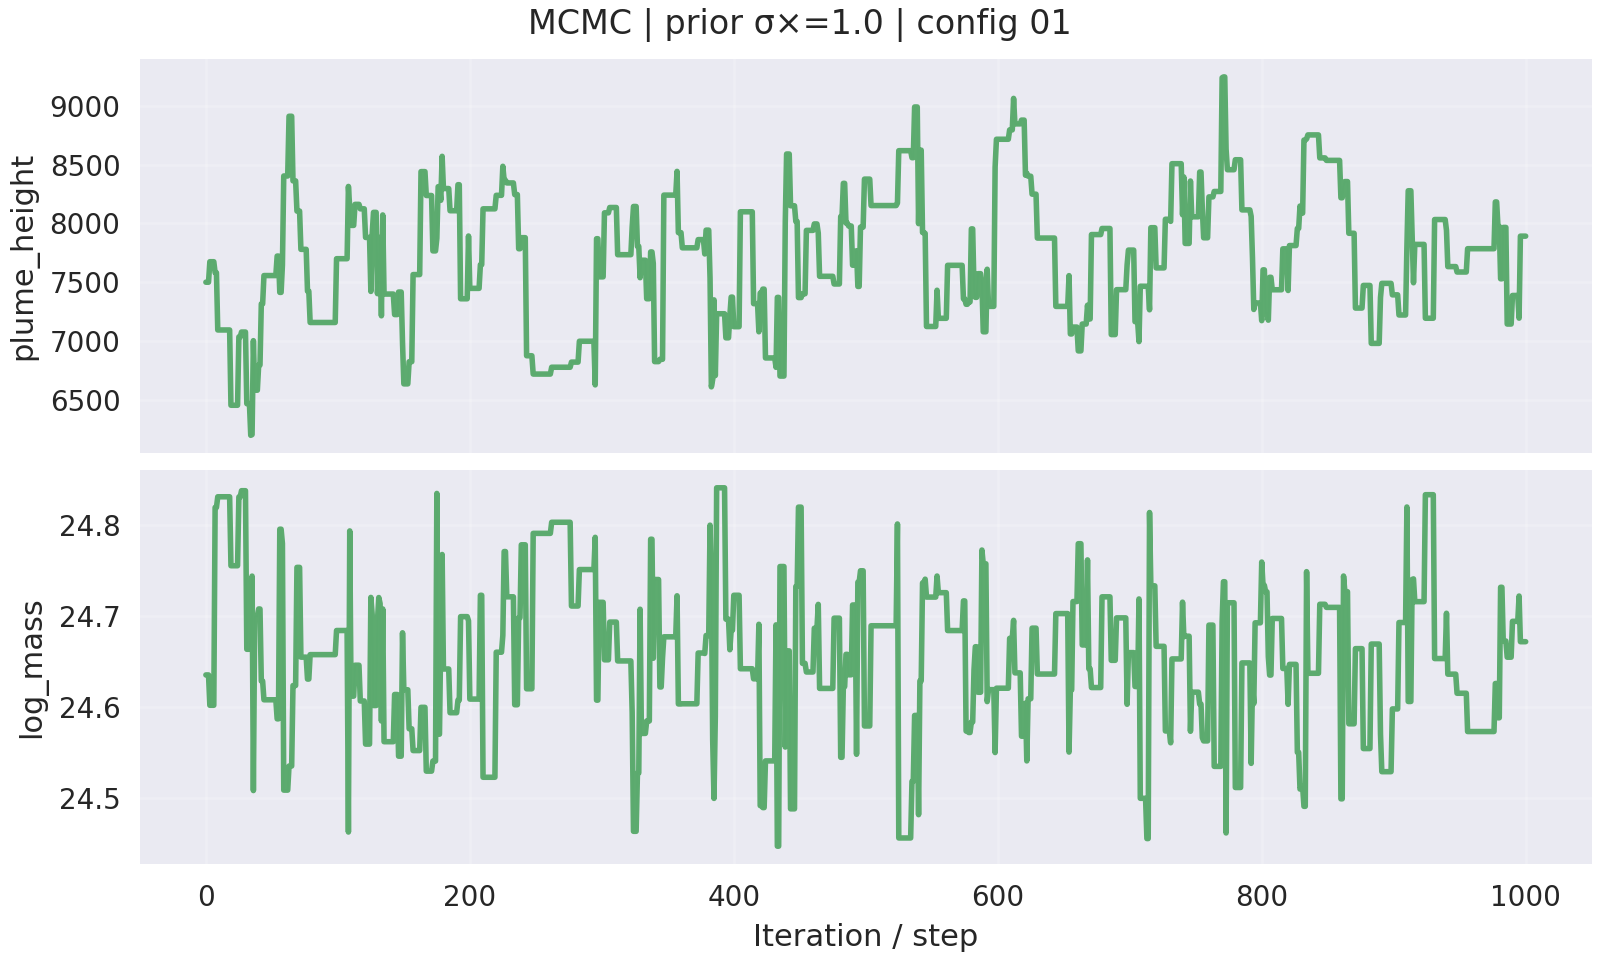

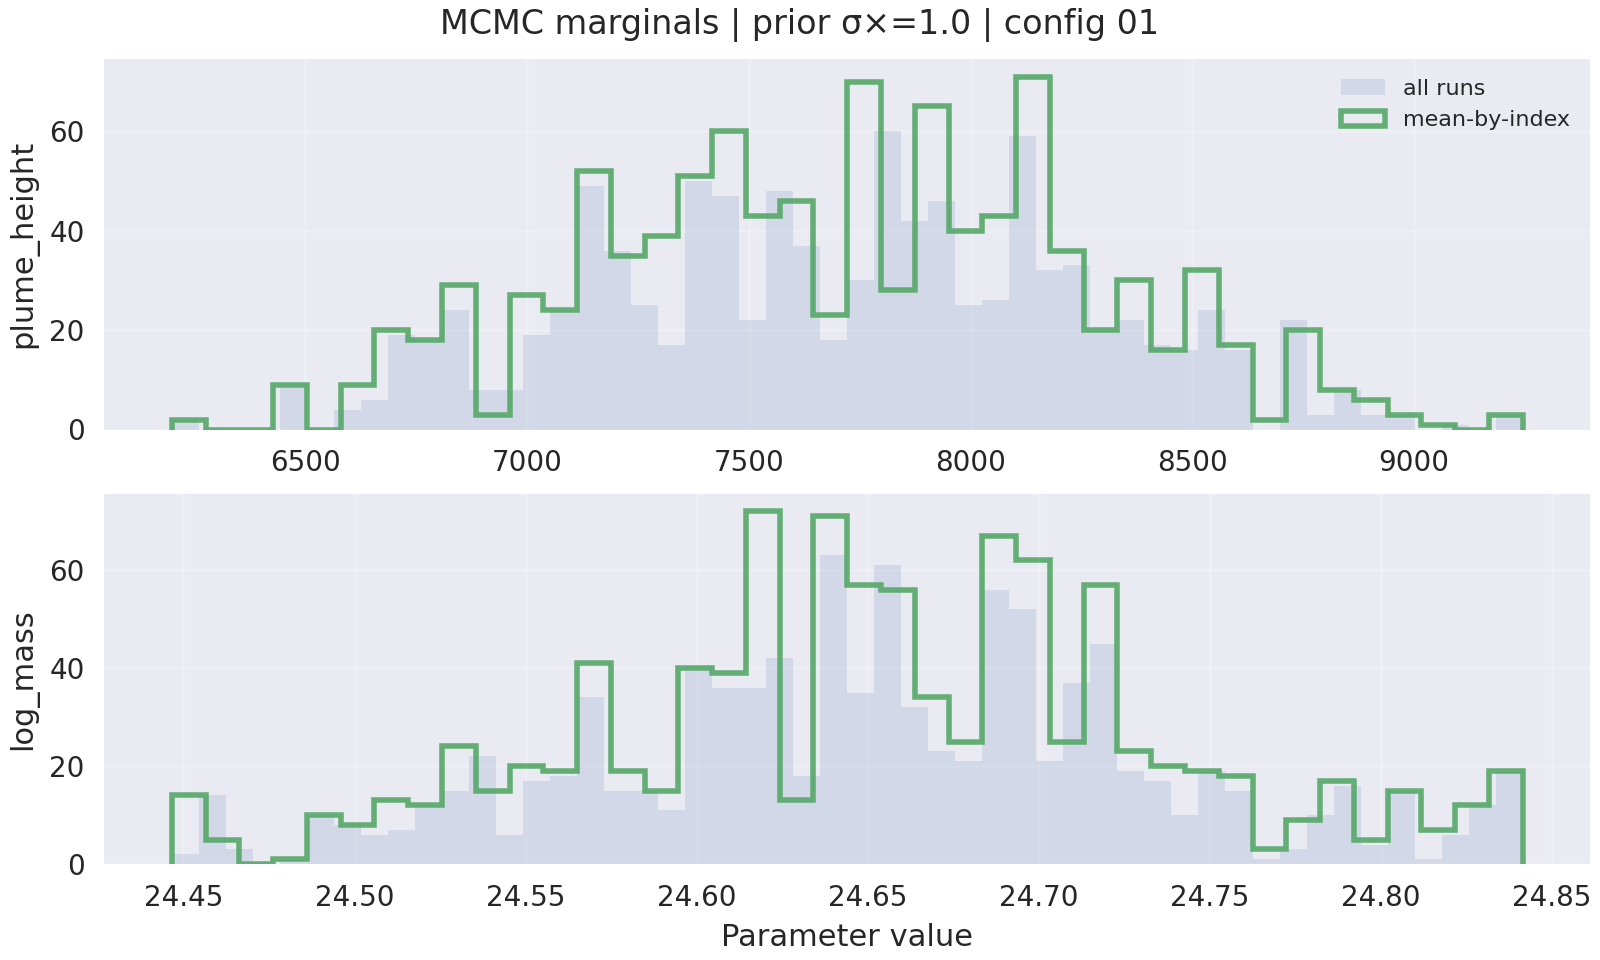

------------------------------------------------------------
MCMC | prior=0.5 | config=02


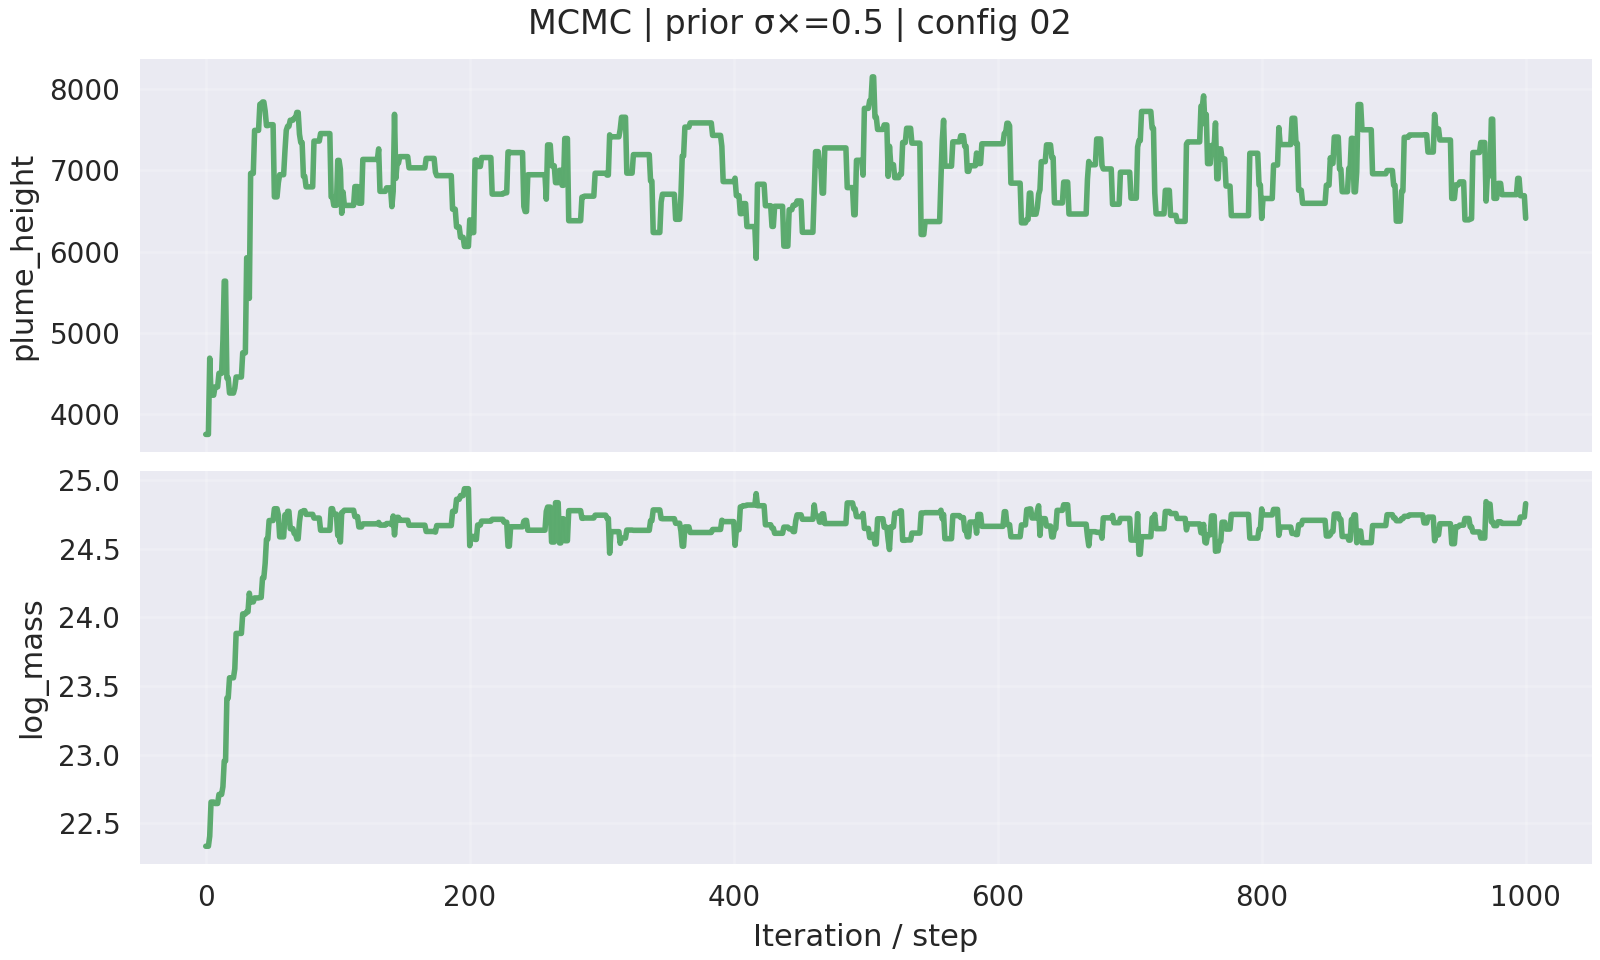

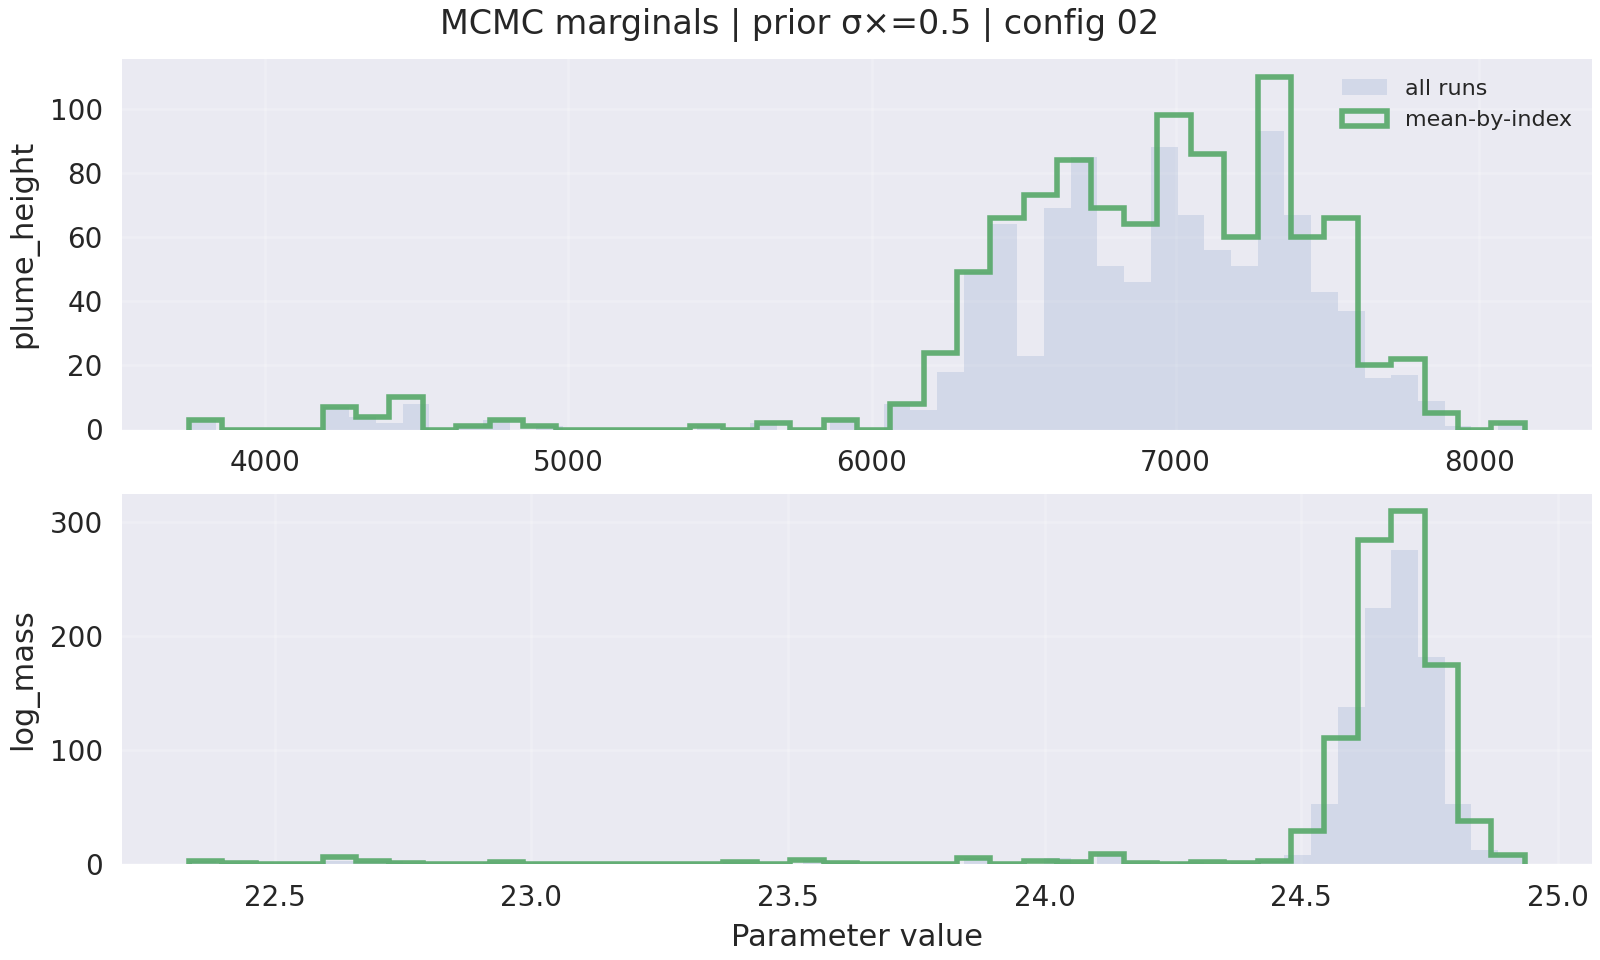

------------------------------------------------------------


In [9]:
from IPython.display import Image, display

for gr in summary:
    print(f"{gr.model.upper()} | prior={gr.prior_factor} | config={gr.config_index:02d}")
    display(Image(filename=str(gr.trace_path)))
    display(Image(filename=str(gr.marginals_path)))
    print("-" * 60)

## Notes on interpretation

* **MCMC**
  * The 10 light traces show how each independent chain evolves.
  * The bold line is the **per-index mean** across chains — if chains mix
    well, this line should stabilise within a reasonable burn-in window.
  * The marginals plot combines all post-burn-in samples across the 10 chains
    (transparent histogram) and overlays the distribution of the mean-by-index
    series (often tighter).

* **SA / PSO**
  * Traces represent optimisation trajectories rather than posterior samples.
  * The shape shows how quickly different repeats converge and whether they
    get “stuck” in similar basins.
  * The histograms show where trajectories spend time; the mean-series
    distribution can suggest how stable converged solutions are across repeats.

* **ES (ensemble smoother)**
  * Each “chain” is whatever summary you saved per run (e.g., ensemble means).
  * Over 10 repeats, the average trajectory reveals how consistently ES pushes
    toward similar parameter regimes under the same prior σ scaling.

In all four methods, the `prior_factor` slices (2.5, 1.0, 0.4) let you see how tightening the prior (smaller σ) moves the balance between data-driven and prior-driven behaviour in a way that is comparable *across* methods.